In [2]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import pickle
import numpy as np 
import importlib

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


# Personnal imports: 
from constants.paths import SAVE_DIRECTORY, FOLDER_PATH
from examples.load_best_config import get_trainer_and_ds_from_saved_trial
from examples.benchmark import local_get_args
from plotting.plotting import get_gain_from_mod1,get_y_size_from_temporal_agg,plot_coverage_matshow,get_df_mase_and_gains,gain_between_models,get_df_gains
from examples.train_model import load_init_model_trainer_ds
from plotting.TS_analysis import plot_TS
from dl_models.full_model import full_model
from trainer import Trainer
from examples.train_and_visu_non_recurrent import train_the_config,get_ds
from examples.train_model import main 
from utils.rng import set_seed

from examples.accuracy_comparison import get_profil_per_horizon,plot_profile_comparison_between_2_prediction,get_predict_real_and_inputs,plot_daily_profile
from examples.accuracy_comparison import get_working_day_daily_profile_on_h,plot_analysis_comparison_2_config
from examples.accuracy_comparison import plot_attn_weights,get_calendar_mask
from examples.accuracy_comparison import get_previous_and_prediction, plot_gain_between_models_with_temporal_agg,load_trainer_ds_from_2_trials,print_global_info,load_trainer_ds_from_1_args

In [3]:
import geopandas as gpd
import folium 
import branca.colormap as cm


def load_subway_gdf(FOLDER_PATH,sptial_unit):
    ref_subway = pd.read_csv(f"{FOLDER_PATH}/ref_subway.csv",index_col =0 ).rename(columns={'MEAN_X':'lon','MEAN_Y':'lat','LIB_STA_SIFO':'Nom'})[['lon','lat','COD_TRG','Nom']]
    ref_subway['geometry'] = gpd.points_from_xy(ref_subway.lon,ref_subway.lat)
    ref_subway = gpd.GeoDataFrame(ref_subway,geometry='geometry',crs='EPSG:4326')[['COD_TRG','Nom','geometry']]
    ref_subway.set_index('COD_TRG',inplace=True)
    ref_subway=ref_subway.reindex(sptial_unit)
    ref_subway.reset_index(inplace=True)
    return ref_subway

def plot_folium_map(gdf, spatial_unit, station_i=0, app_tag_mode = 'Web_Weather_iris_DL', VMIN=None, VMAX=None):

    # ---- Load subway gdf: 
    ref_subway = load_subway_gdf(FOLDER_PATH,spatial_unit)
    
    # ---- Init Folium Map ----
    gdf_map = gdf.to_crs(epsg=4326)
    m = folium.Map(location=[45.78,4.85], zoom_start=12, tiles='CartoDB positron')
    # ----

    # ---- Coropleth on Attention Weights ----
    colormap = cm.LinearColormap(
        colors=['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000'], # Colors of 'OrRd' palette
        vmin=VMIN,
        vmax=VMAX,
        caption=f"Attention weights Distribution of IRIS zones with {' '.join(app_tag_mode.split('_')[:-2])} app ({app_tag_mode.split('_')[-1]}) at Station {spatial_unit[station_i]}"
    )

    # A function to determine the color for each feature based on its value
    data_dict = gdf_map.set_index('NOM_IRIS')[app_tag_mode].to_dict()
    def style_function(feature):
        # Get the value from the data dictionary using the 'NOM_IRIS' key
        iris_name = feature['properties']['NOM_IRIS']
        value = data_dict.get(iris_name, None)

        # Use the colormap to get the corresponding color
        if value is not None:
            color = colormap(value)
        else:
            # Assign a default color for missing data
            color = 'white'

        return {
            'fillColor': color,
            'color': 'black',  # Line color
            'weight': 1,       # Line weight (thickness)
            'fillOpacity': 0.7,
            'line_opacity': 0.3
        }

    # Add the GeoJson layer to the map
    # We use the style_function to color each polygon
    geojson = folium.GeoJson(
        gdf_map.to_json(),
        name='choropleth',
        style_function=style_function,
        highlight_function=lambda x: {'weight': 3, 'color': 'black'}, # Highlight on hover
        tooltip=folium.GeoJsonTooltip(fields=['NOM_IRIS', app_tag_mode,f"{app_tag_mode}_channel_spatial"])
    ).add_to(m)

    # Add the legend from the colormap to the map
    colormap.add_to(m)
    # ----



    # ---- Add interactive tools 
    # Interactive Keyword args 
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.1, 'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}

    tooltip_layer = folium.features.GeoJson(
        gdf_map,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['NOM_IRIS', app_tag_mode,f"{app_tag_mode}_channel_spatial"],
            aliases=['IRIS Name: ', 'Value: ', 'Channel-Spatial Unit:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )
    )
    m.add_child(tooltip_layer)
    m.keep_in_front(tooltip_layer)
    # ----

    # ---- Add Subway Stations ----
    for index, station in ref_subway.iterrows():
        lat = station.geometry.y
        lon = station.geometry.x
        
        # Par défaut, une croix grise
        svg_cross = """
        <svg width="20" height="20" viewBox="0 0 20 20" xmlns="http://www.w3.org/2000/svg" style="transform: rotate(45deg);">
        <line x1="9" y1="3" x2="9" y2="15" stroke="grey" stroke-width="2.5" />
        <line x1="3" y1="9" x2="15" y2="9" stroke="grey" stroke-width="2.5" />
        </svg>
        """

        # Si l'index correspond à la station spéciale
        if index == station_i:
            svg_cross ="""
            <svg width="20" height="20" viewBox="0 0 20 20" xmlns="http://www.w3.org/2000/svg" style="transform: rotate(45deg);">
        <line x1="10" y1="0" x2="10" y2="20" stroke="purple" stroke-width="4.5" />
        <line x1="0" y1="10" x2="20" y2="10" stroke="purple" stroke-width="4.5" />
        </svg>
        """

        # Création du marqueur avec l'icône personnalisée
        # Use DivIcon to wrap the SVG
        cross_icon = folium.DivIcon(
            icon_size=(20, 20),
            icon_anchor=(10, 10), # Anchors the icon at its center
            html=svg_cross
        )
        folium.Marker(
            location=[lat, lon],
            tooltip=station['Nom'], # Tooltip qui s'affiche au survol
            icon=cross_icon
        ).add_to(m)
    # ----


    # 5. Add a layer control panel
    folium.LayerControl().add_to(m)

    # To display the map in a Jupyter Notebook or similar environment, simply have 'm' as the last line.
    return m 


def set_attention_weights_agregated_per_daily_period(gdf,NetMob_attn_weights, 
                                                     station_i,head, mask, agg_iris_target_n,
                                                     dict_agg2label,list_correspondence):
    if agg_iris_target_n is None:
        agg_iris_target_n = len(gdf)
    gdf_copy = gdf.copy()
    for channel_spatial_unit in range(NetMob_attn_weights.size(-1)):
        init_labels = dict_agg2label[channel_spatial_unit]
        list_range = [range(k*agg_iris_target_n,(k+1)*agg_iris_target_n) for k in range(len(list_correspondence))]
        is_associated_to_an_unique_app = [all([label in range_agg_iris_target_n for label in init_labels]) for range_agg_iris_target_n in list_range]

        # If it's associated to an unique app: 
        assert sum(is_associated_to_an_unique_app) < 2, 'Issue with the discretisation'
        if sum(is_associated_to_an_unique_app) > 0:
            # Attention weight at head 'head' and station 'station_i'.  
            attn_weight_head_i = NetMob_attn_weights[:,head,station_i,:]  # [T,n_head,N,channel_spatial_units] -> [T,channel_spatial_units]

            # Fin the associated app: 
            app_tag_mode = list_correspondence[np.where(np.array(is_associated_to_an_unique_app) == True)[0][0]]

            # Find the associated zones 
            reduced_init_labels = [init_labels[i]%agg_iris_target_n for i in range(len(init_labels))]

            # Specifie daily period (morning peak on working day ...) :
            attn_weight_head_i = torch.index_select(attn_weight_head_i.detach().cpu(),0, torch.tensor(mask).long())

            # Add the attention weights to the gdf:
            gdf_copy.loc[reduced_init_labels,app_tag_mode] = attn_weight_head_i.mean(0)[channel_spatial_unit].detach().cpu()
            gdf_copy.loc[reduced_init_labels,f'{app_tag_mode}_channel_spatial'] = channel_spatial_unit
        else:
            if len(list_correspondence) == 2:
                app_tag_mode = list_correspondence
                print('mix of apps: ',init_labels)
            else:
                raise NotImplementedError
    return gdf_copy

In [38]:
import pandas as pd
import re
import io

# La chaîne de caractères brute contenant tous les résultats.
results_string = """
_subway_out_subway_in_calendar_embedding_h1: All Steps RMSE = 32.35, MAE = 18.14, MAPE = 22.47, MSE = 1046.60
_subway_out_subway_in_bike_in_calendar_embedding_h1: All Steps RMSE = 31.56, MAE = 18.05, MAPE = 21.73, MSE = 995.97
_subway_out_subway_in_bike_out_calendar_embedding_h1: All Steps RMSE = 31.54, MAE = 17.90, MAPE = 22.21, MSE = 994.63
_subway_out_subway_in_bike_in_bike_out_calendar_embedding_h1: All Steps RMSE = 31.60, MAE = 17.93, MAPE = 21.64, MSE = 998.51
_subway_out_bike_in_calendar_embedding_h1: All Steps RMSE = 32.73, MAE = 18.86, MAPE = 22.78, MSE = 1071.53
_subway_out_bike_in_bike_out_calendar_embedding_h1: All Steps RMSE = 32.59, MAE = 18.83, MAPE = 23.87, MSE = 1062.37
_subway_out_bike_out_calendar_embedding_h1: All Steps RMSE = 32.24, MAE = 18.37, MAPE = 22.88, MSE = 1039.71
_subway_out_calendar_embedding_h1: All Steps RMSE = 32.44, MAE = 18.52, MAPE = 23.61, MSE = 1052.31
_subway_out_subway_in_calendar_embedding_h2: All Steps RMSE = 33.76, MAE = 19.19, MAPE = 23.60, MSE = 1139.43
_subway_out_subway_in_bike_in_calendar_embedding_h2: All Steps RMSE = 34.34, MAE = 19.50, MAPE = 23.77, MSE = 1178.90
_subway_out_subway_in_bike_out_calendar_embedding_h2: All Steps RMSE = 33.17, MAE = 18.95, MAPE = 23.20, MSE = 1100.45
_subway_out_subway_in_bike_in_bike_out_calendar_embedding_h2: All Steps RMSE = 34.38, MAE = 19.55, MAPE = 24.52, MSE = 1181.79
_subway_out_bike_in_calendar_embedding_h2: All Steps RMSE = 34.14, MAE = 19.50, MAPE = 24.36, MSE = 1165.67
_subway_out_bike_in_bike_out_calendar_embedding_h2: All Steps RMSE = 34.68, MAE = 19.76, MAPE = 23.69, MSE = 1202.67
_subway_out_bike_out_calendar_embedding_h2: All Steps RMSE = 34.42, MAE = 19.55, MAPE = 23.51, MSE = 1184.84
_subway_out_calendar_embedding_h2: All Steps RMSE = 34.56, MAE = 19.56, MAPE = 23.93, MSE = 1194.15
_subway_out_subway_in_calendar_embedding_h3: All Steps RMSE = 36.18, MAE = 20.37, MAPE = 24.82, MSE = 1309.33
_subway_out_subway_in_bike_in_calendar_embedding_h3: All Steps RMSE = 36.24, MAE = 20.26, MAPE = 25.85, MSE = 1313.58
_subway_out_subway_in_bike_out_calendar_embedding_h3: All Steps RMSE = 36.02, MAE = 20.50, MAPE = 25.92, MSE = 1297.59
_subway_out_subway_in_bike_in_bike_out_calendar_embedding_h3: All Steps RMSE = 34.92, MAE = 20.00, MAPE = 25.15, MSE = 1219.14
_subway_out_bike_in_calendar_embedding_h3: All Steps RMSE = 35.95, MAE = 20.57, MAPE = 26.82, MSE = 1292.21
_subway_out_bike_in_bike_out_calendar_embedding_h3: All Steps RMSE = 35.51, MAE = 20.36, MAPE = 25.12, MSE = 1261.00
_subway_out_bike_out_calendar_embedding_h3: All Steps RMSE = 37.51, MAE = 21.06, MAPE = 26.61, MSE = 1407.23
_subway_out_calendar_embedding_h3: All Steps RMSE = 35.39, MAE = 20.02, MAPE = 24.87, MSE = 1252.18
_subway_out_subway_in_calendar_embedding_h4: All Steps RMSE = 37.13, MAE = 21.06, MAPE = 26.83, MSE = 1378.35
_subway_out_subway_in_bike_in_calendar_embedding_h4: All Steps RMSE = 38.52, MAE = 21.73, MAPE = 27.82, MSE = 1483.62
_subway_out_subway_in_bike_out_calendar_embedding_h4: All Steps RMSE = 38.72, MAE = 21.53, MAPE = 27.56, MSE = 1498.98
_subway_out_subway_in_bike_in_bike_out_calendar_embedding_h4: All Steps RMSE = 37.59, MAE = 21.48, MAPE = 27.21, MSE = 1413.12
_subway_out_bike_in_calendar_embedding_h4: All Steps RMSE = 36.97, MAE = 21.06, MAPE = 26.54, MSE = 1366.53
_subway_out_bike_in_bike_out_calendar_embedding_h4: All Steps RMSE = 38.07, MAE = 21.66, MAPE = 27.72, MSE = 1449.69
_subway_out_bike_out_calendar_embedding_h4: All Steps RMSE = 37.29, MAE = 20.84, MAPE = 26.21, MSE = 1390.92
_subway_out_calendar_embedding_h4: All Steps RMSE = 36.76, MAE = 20.76, MAPE = 26.01, MSE = 1351.52
_subway_in_subway_out_calendar_embedding_h1: All Steps RMSE = 33.17, MAE = 19.49, MAPE = 24.34, MSE = 1100.35
_subway_in_subway_out_bike_in_calendar_embedding_h1: All Steps RMSE = 33.87, MAE = 20.01, MAPE = 25.52, MSE = 1146.98
_subway_in_subway_out_bike_out_calendar_embedding_h1: All Steps RMSE = 33.48, MAE = 19.75, MAPE = 26.43, MSE = 1120.81
_subway_in_subway_out_bike_in_bike_out_calendar_embedding_h1: All Steps RMSE = 33.91, MAE = 20.03, MAPE = 25.10, MSE = 1149.81
_subway_in_bike_in_calendar_embedding_h1: All Steps RMSE = 33.12, MAE = 19.34, MAPE = 24.72, MSE = 1096.74
_subway_in_bike_in_bike_out_calendar_embedding_h1: All Steps RMSE = 33.56, MAE = 19.62, MAPE = 25.54, MSE = 1126.06
_subway_in_bike_out_calendar_embedding_h1: All Steps RMSE = 33.15, MAE = 19.24, MAPE = 23.57, MSE = 1099.04
_subway_in_calendar_embedding_h1: All Steps RMSE = 33.07, MAE = 19.48, MAPE = 26.94, MSE = 1093.76
_subway_in_subway_out_calendar_embedding_h2: All Steps RMSE = 35.85, MAE = 20.80, MAPE = 25.81, MSE = 1285.47
_subway_in_subway_out_bike_in_calendar_embedding_h2: All Steps RMSE = 35.34, MAE = 20.40, MAPE = 26.53, MSE = 1249.00
_subway_in_subway_out_bike_out_calendar_embedding_h2: All Steps RMSE = 35.43, MAE = 20.36, MAPE = 25.66, MSE = 1254.97
_subway_in_subway_out_bike_in_bike_out_calendar_embedding_h2: All Steps RMSE = 35.95, MAE = 20.98, MAPE = 27.04, MSE = 1292.13
_subway_in_bike_in_calendar_embedding_h2: All Steps RMSE = 35.38, MAE = 20.72, MAPE = 29.00, MSE = 1251.98
_subway_in_bike_in_bike_out_calendar_embedding_h2: All Steps RMSE = 35.57, MAE = 20.60, MAPE = 26.41, MSE = 1265.04
_subway_in_bike_out_calendar_embedding_h2: All Steps RMSE = 35.56, MAE = 20.54, MAPE = 25.83, MSE = 1264.19
_subway_in_calendar_embedding_h2: All Steps RMSE = 35.40, MAE = 20.36, MAPE = 25.41, MSE = 1252.84
_subway_in_subway_out_calendar_embedding_h3: All Steps RMSE = 37.88, MAE = 21.47, MAPE = 26.98, MSE = 1434.56
_subway_in_subway_out_bike_in_calendar_embedding_h3: All Steps RMSE = 37.79, MAE = 21.59, MAPE = 28.69, MSE = 1427.89
_subway_in_subway_out_bike_out_calendar_embedding_h3: All Steps RMSE = 38.93, MAE = 22.14, MAPE = 28.74, MSE = 1515.45
_subway_in_subway_out_bike_in_bike_out_calendar_embedding_h3: All Steps RMSE = 37.06, MAE = 21.44, MAPE = 27.69, MSE = 1373.73
_subway_in_bike_in_calendar_embedding_h3: All Steps RMSE = 36.99, MAE = 21.60, MAPE = 29.81, MSE = 1368.10
_subway_in_bike_in_bike_out_calendar_embedding_h3: All Steps RMSE = 36.20, MAE = 20.88, MAPE = 26.74, MSE = 1310.28
_subway_in_bike_out_calendar_embedding_h3: All Steps RMSE = 37.95, MAE = 21.58, MAPE = 26.32, MSE = 1440.30
_subway_in_calendar_embedding_h3: All Steps RMSE = 38.10, MAE = 21.70, MAPE = 29.72, MSE = 1451.54
_subway_in_subway_out_calendar_embedding_h4: All Steps RMSE = 39.45, MAE = 22.26, MAPE = 28.73, MSE = 1556.68
_subway_in_subway_out_bike_in_calendar_embedding_h4: All Steps RMSE = 38.34, MAE = 22.15, MAPE = 27.22, MSE = 1469.73
_subway_in_subway_out_bike_out_calendar_embedding_h4: All Steps RMSE = 40.11, MAE = 22.97, MAPE = 30.86, MSE = 1609.03
_subway_in_subway_out_bike_in_bike_out_calendar_embedding_h4: All Steps RMSE = 40.51, MAE = 22.83, MAPE = 28.94, MSE = 1641.39
_subway_in_bike_in_calendar_embedding_h4: All Steps RMSE = 39.28, MAE = 22.27, MAPE = 28.29, MSE = 1543.21
_subway_in_bike_in_bike_out_calendar_embedding_h4: All Steps RMSE = 40.72, MAE = 23.49, MAPE = 29.43, MSE = 1658.51
_subway_in_bike_out_calendar_embedding_h4: All Steps RMSE = 38.54, MAE = 21.83, MAPE = 27.84, MSE = 1485.09
_subway_in_calendar_embedding_h4: All Steps RMSE = 39.77, MAE = 22.75, MAPE = 29.64, MSE = 1581.47
"""

def parse_results_to_dataframe(data_string):
    """
    Analyse une chaîne de caractères de résultats de modèles pour la convertir en DataFrame Pandas.
    """
    # Utilise io.StringIO pour lire la chaîne de caractères multi-lignes comme un fichier.
    lines = io.StringIO(data_string).readlines()
    
    parsed_data = []

    # Correspondance entre l'horizon et le temps
    horizon_map = {
        'h1': '+15min',
        'h2': '+30min',
        'h3': '+45min',
        'h4': '+60min', # Correction du h5 de la demande en h4 présent dans les données
    }

    # Expression régulière pour extraire les informations de chaque ligne
    # Elle capture le nom de l'expérience et les valeurs des métriques.
    line_regex = re.compile(r"(_\w+):.*?RMSE = ([\d.]+), MAE = ([\d.]+), MAPE = ([\d.]+)")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        match = line_regex.search(line)
        if not match:
            continue
            
        # Extrait les parties de la ligne
        description, rmse, mae, mape = match.groups()
        parts = description.strip('_').split('_')

        # Identifie la donnée cible (target) et les données contextuelles
        target_data = f"{parts[0]}_{parts[1]}"
        context_parts = '_'.join(parts[2:-3]) # Ignore target, calendar, embedding, et horizon

        # Trouve l'horizon de prédiction
        horizon_code = parts[-1]
        horizon = horizon_map.get(horizon_code, 'N/A')

        # Crée un dictionnaire pour stocker les informations de la ligne
        row = {
            'target_data': target_data,
            'subway_in': 'subway_in' in context_parts,
            'subway_out': 'subway_out' in context_parts,
            'bike_in': 'bike_in' in context_parts,
            'bike_out': 'bike_out' in context_parts,
            'horizon': horizon,
            'horizon_code': horizon_code, # Ajout pour le tri
            'RMSE': float(rmse),
            'MAE': float(mae),
            'MAPE': float(mape),
        }
        parsed_data.append(row)

    if not parsed_data:
        return pd.DataFrame()

    # Crée le DataFrame
    df = pd.DataFrame(parsed_data)
    
    # Trie les valeurs comme demandé : par cible, puis par horizon
    df = df.sort_values(by=['target_data', 'horizon_code']).reset_index(drop=True)
    
    # Réorganise et supprime les colonnes non nécessaires pour l'affichage final
    final_columns = [
        'target_data', 'horizon', 
        'subway_in', 'subway_out', 
        'bike_in', 'bike_out',
        'RMSE', 'MAE', 'MAPE'
    ]
    df = df[final_columns]
    
    return df

# Exécute la fonction et affiche le DataFrame
results_df = parse_results_to_dataframe(results_string)
results_df.columns = ['\_'.join(c.split('_')) for c in results_df.columns]
for metric in ['RMSE','MAE','MAPE']:
    results_df[metric] =  results_df[metric].apply(lambda x : '{:.2f}'.format(x))
df_subway_in = results_df[results_df['target\_data'] == 'subway_in'].copy()
df_subway_out = results_df[results_df['target\_data'] == 'subway_out'].copy()
for col in df_subway_in.columns:
    df_subway_in[col] = df_subway_in[col].replace({True: '\\checkmark', False: ''})
for col in df_subway_out.columns:
    df_subway_out[col] = df_subway_out[col].replace({True: '\\checkmark', False: ''})

df_subway_in=df_subway_in.drop(columns = ['target\_data','subway\_in']).set_index('horizon')
df_subway_out=df_subway_out.drop(columns = ['target\_data','subway\_out']).set_index('horizon')

# Affiche les DataFrames séparés par target_data pour une meilleure lisibilité
print("%--- DataFrame pour Target Data: subway_in ---")
print('\\begin{frame}')
print('    \\begin{table}[htbp]')
print('        \\centering')
print('        \\tiny')
print("        \\caption{Résultats des prédictions pour la cible 'subway\_in'}")
print("        \\label{tab:results_subway_in}")
# print("        \\begin{tabular}{cccc|ccc}")
print(df_subway_in.to_latex())
print("    \end{table}")
print("\end{frame}")


print("\n\n%--- DataFrame pour Target Data: subway_out ---")
print('\\begin{frame}')
print('    \\begin{table}[htbp]')
print('        \\centering')
print('        \\tiny')
print("        \\caption{Résultats des prédictions pour la cible 'subway\_out'}")
print("        \\label{tab:results_subway_out}")
print(df_subway_out.to_latex())
print("    \end{table}")
print("\end{frame}")

%--- DataFrame pour Target Data: subway_in ---
\begin{frame}
    \begin{table}[htbp]
        \centering
        \tiny
        \caption{Résultats des prédictions pour la cible 'subway\_in'}
        \label{tab:results_subway_in}
\begin{tabular}{lllllll}
\toprule
 & subway\_out & bike\_in & bike\_out & RMSE & MAE & MAPE \\
horizon &  &  &  &  &  &  \\
\midrule
+15min & \checkmark &  &  & 33.17 & 19.49 & 24.34 \\
+15min & \checkmark & \checkmark &  & 33.87 & 20.01 & 25.52 \\
+15min & \checkmark &  & \checkmark & 33.48 & 19.75 & 26.43 \\
+15min & \checkmark & \checkmark & \checkmark & 33.91 & 20.03 & 25.10 \\
+15min &  & \checkmark &  & 33.12 & 19.34 & 24.72 \\
+15min &  & \checkmark & \checkmark & 33.56 & 19.62 & 25.54 \\
+15min &  &  & \checkmark & 33.15 & 19.24 & 23.57 \\
+15min &  &  &  & 33.07 & 19.48 & 26.94 \\
+30min & \checkmark &  &  & 35.85 & 20.80 & 25.81 \\
+30min & \checkmark & \checkmark &  & 35.34 & 20.40 & 26.53 \\
+30min & \checkmark &  & \checkmark & 35.43 & 20.36 & 25.66 

# Comparison of 5 iterations of the same model: 

In [7]:
for target_data in ['subway_out']:
    for horizon in [1,2,3,4]:
        print('\n')
        for contextual_dataset_names in [[], ['subway_in','bike_in'],['subway_in'],['bike_in'] ]: 
            dataset_names =  [target_data] +contextual_dataset_names+ ['calendar_embedding']
            if contextual_dataset_names == []:
                print(f"trial_id1 = {'_'.join(dataset_names)}_h{horizon}_bis")
            else:
                print(f"trial_id2 = {'_'.join(dataset_names)}_h{horizon}_bis")



trial_id1 = subway_out_calendar_embedding_h1_bis
trial_id2 = subway_out_subway_in_bike_in_calendar_embedding_h1_bis
trial_id2 = subway_out_subway_in_calendar_embedding_h1_bis
trial_id2 = subway_out_bike_in_calendar_embedding_h1_bis


trial_id1 = subway_out_calendar_embedding_h2_bis
trial_id2 = subway_out_subway_in_bike_in_calendar_embedding_h2_bis
trial_id2 = subway_out_subway_in_calendar_embedding_h2_bis
trial_id2 = subway_out_bike_in_calendar_embedding_h2_bis


trial_id1 = subway_out_calendar_embedding_h3_bis
trial_id2 = subway_out_subway_in_bike_in_calendar_embedding_h3_bis
trial_id2 = subway_out_subway_in_calendar_embedding_h3_bis
trial_id2 = subway_out_bike_in_calendar_embedding_h3_bis


trial_id1 = subway_out_calendar_embedding_h4_bis
trial_id2 = subway_out_subway_in_bike_in_calendar_embedding_h4_bis
trial_id2 = subway_out_subway_in_calendar_embedding_h4_bis
trial_id2 = subway_out_bike_in_calendar_embedding_h4_bis


----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14965, 40, 7])
   VALID contextual_ds: torch.Size([4989, 40, 7])
   TEST contextual_ds: torch.Size([4988, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP

>>>Tackle Contextual dataset:  subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv


Restraining all datasets to train common dates: 14965 dates
Restraining all datasets to valid common dates: 4989 dates
Restraining all datasets to test common date

[2025-08-16 23:38:48,999] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/rrochas/prediction-validation/dl_models/TimeEmbedding/time_embedding.py:102)
   reasons:  ___guarded_code.valid
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.
[2025-08-16 23:38:49,181] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/nn/modules/container.py:215)
   reasons:  ___guarded_code.valid
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.
[2025-08-16 23:38:51,507] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/rrochas/prediction-validation/dl_models/STGCN/STGCN_layer.py:472)
   reasons:  ___guarded_code.valid
to diagnose recompilation issues, s

Model1 correspond to :  subway_out_subway_in_calendar_embedding_h2_bis
Model2 correspond to :  subway_out_subway_in_bike_in_calendar_embedding_h2_bis
Global MAE gain (%) from Model2 compared to Model1 at horizon 2: 0.12 // All horizon : 0.12
Global MSE gain (%) from Model2 compared to Model1 at horizon 2: -0.69 // All horizon : -0.69
Global RMSE gain (%) from Model2 compared to Model1 at horizon 2: -0.35 // All horizon : -0.35


Loading BokehJS ...

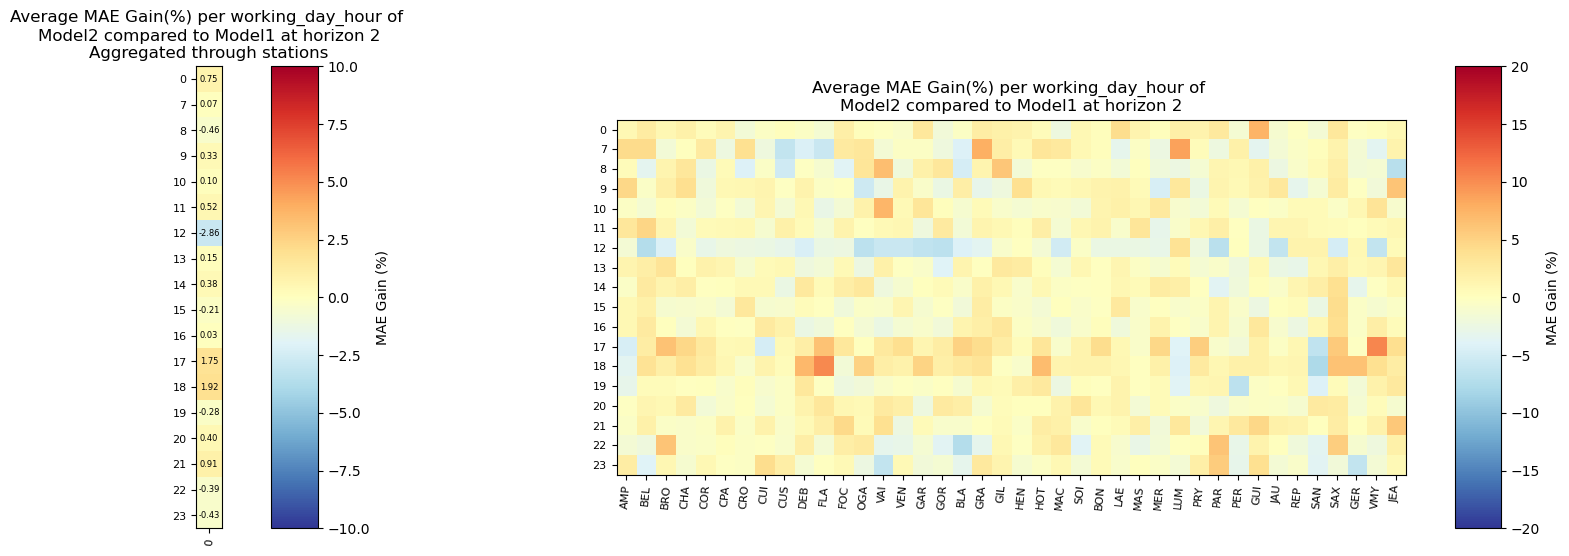

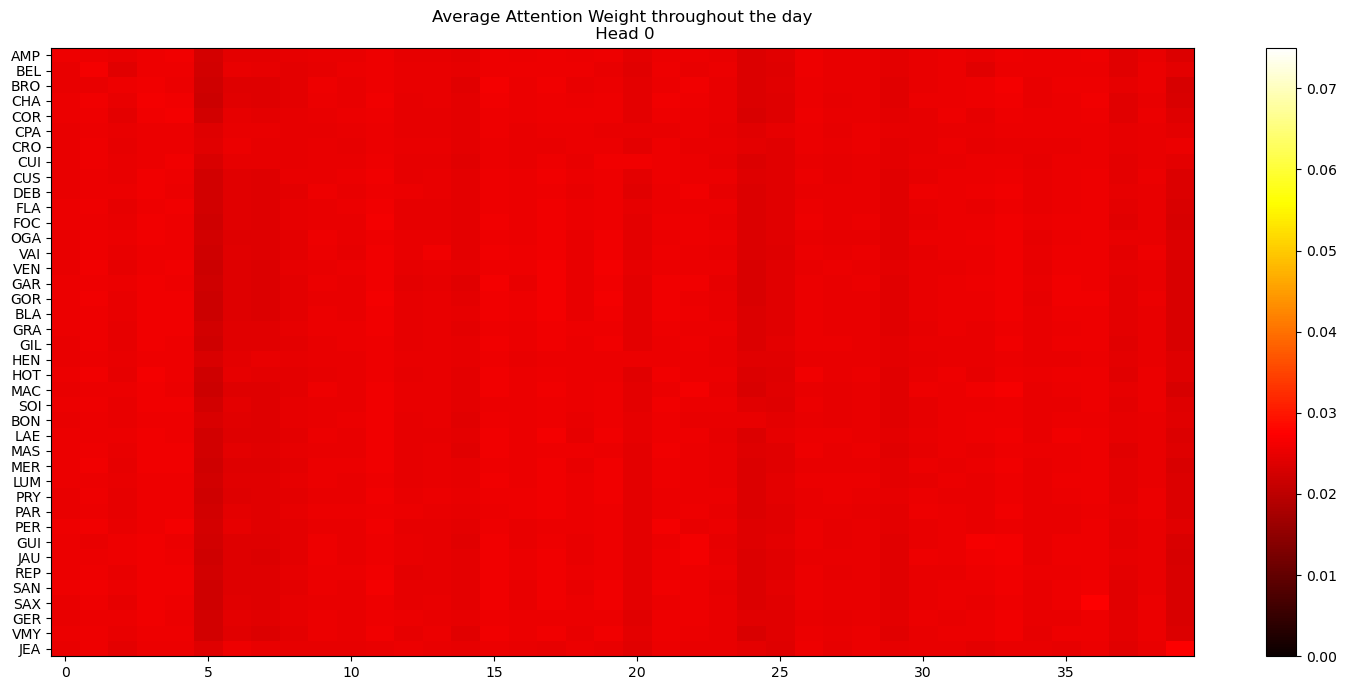

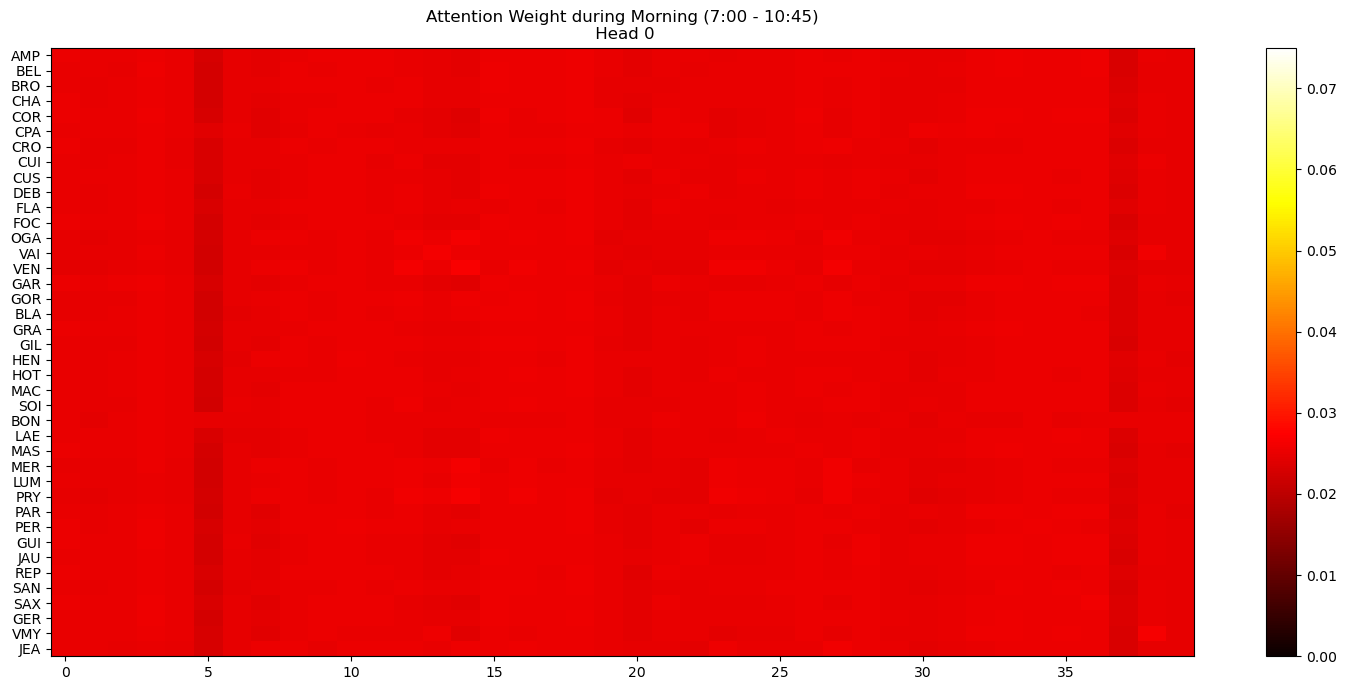

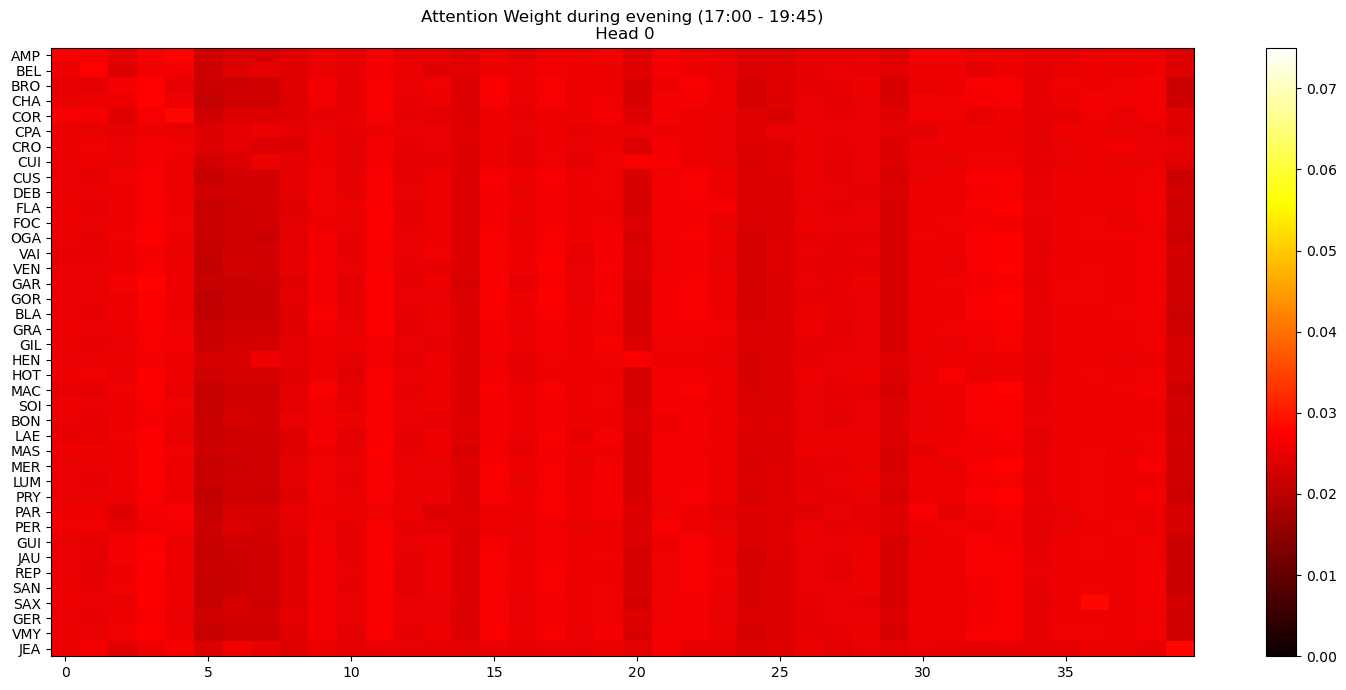

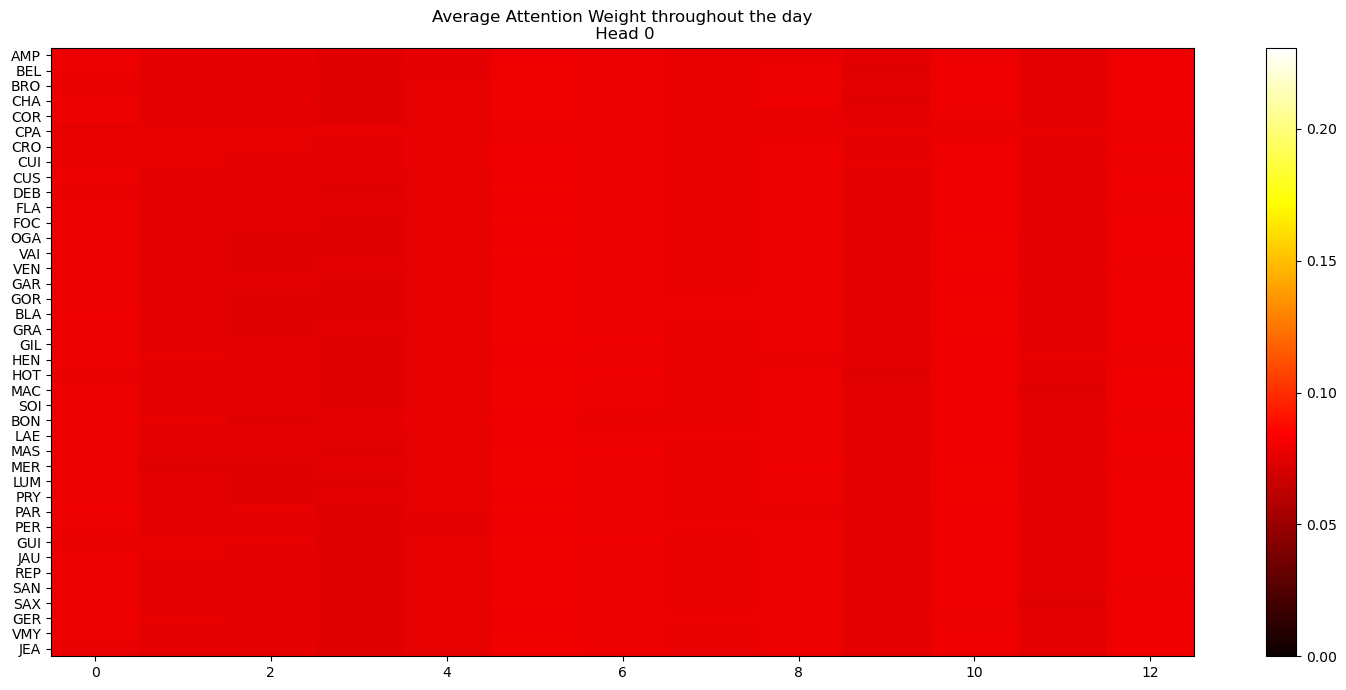

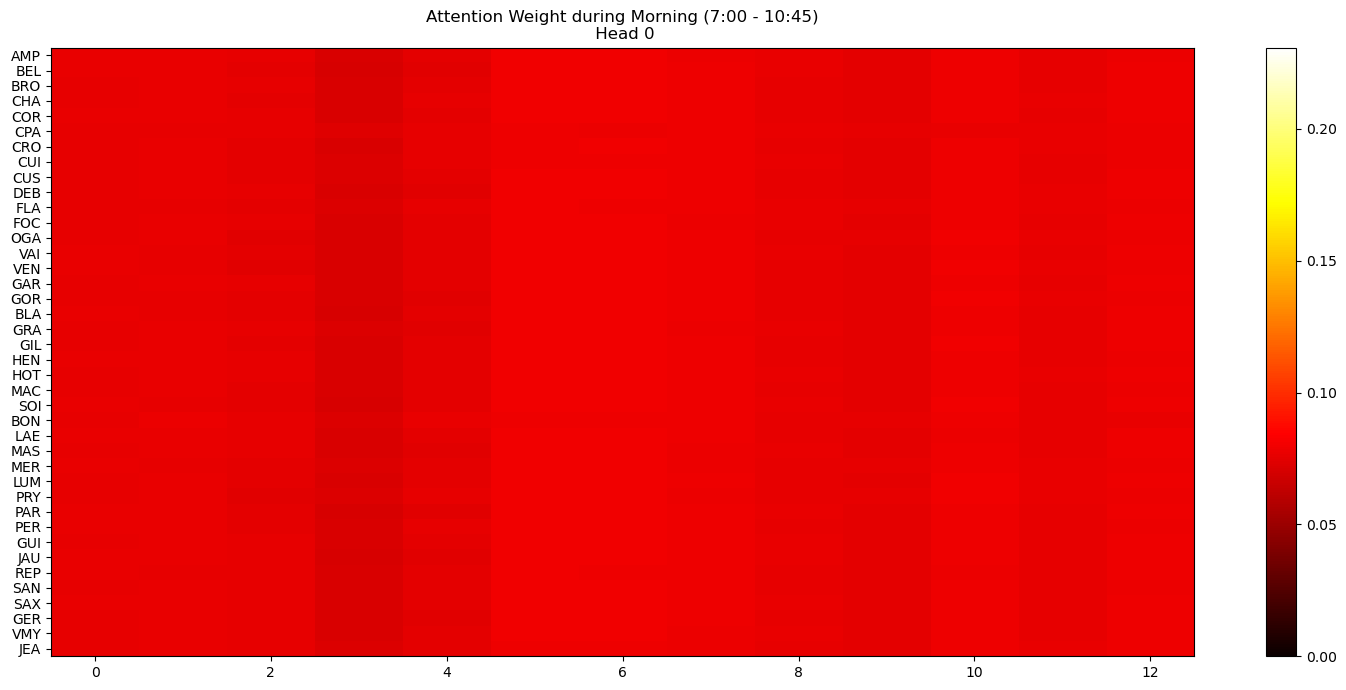

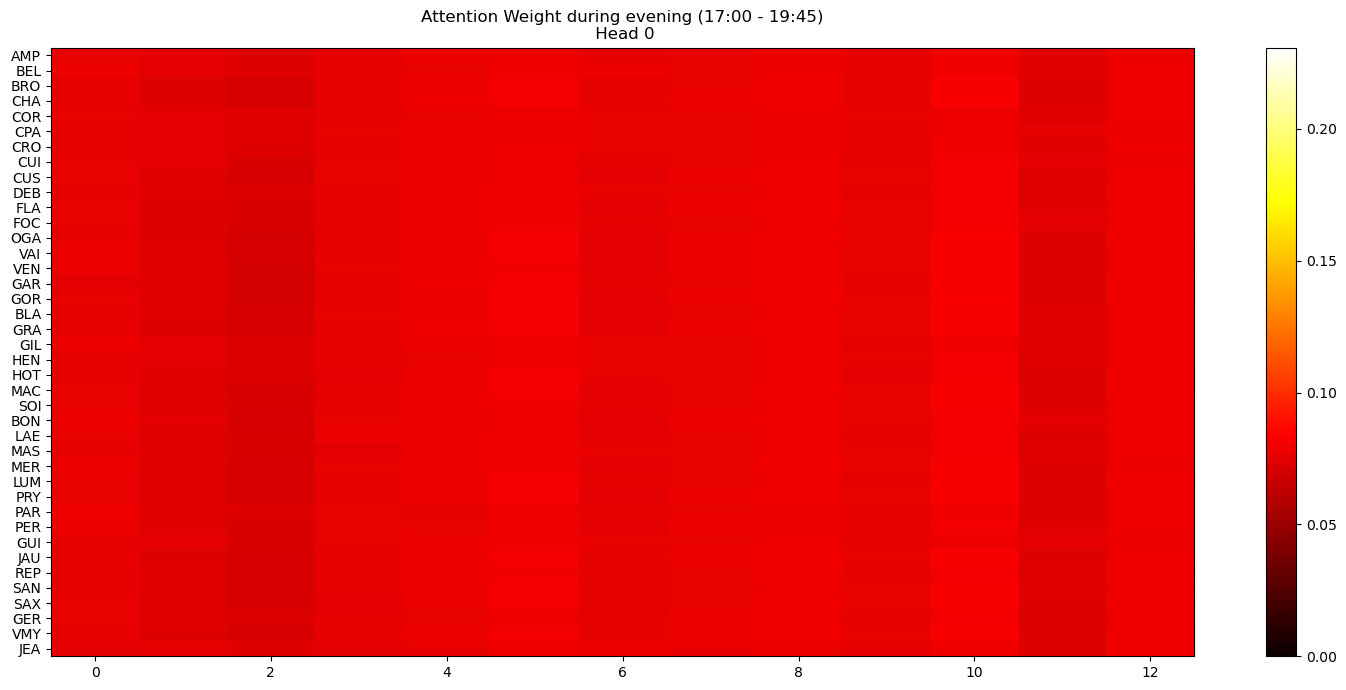

In [19]:
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
training_mode = 'test'


## -----------------FULL DATA 1 AN---------------------------------------------------------------------------------------------------------
## Prediction on 4 consecutives horizons 

# ## Prediction on HORIZON 1
# trial_id1 = 'subway_out_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h1_bis'

# ## Prediction on HORIZON 2
# trial_id1 = 'subway_out_calendar_embedding_h2_bis'
trial_id1 = 'subway_out_subway_in_calendar_embedding_h2_bis'
trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h2_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h2_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h2_bis'

# ## Prediction on HORIZON 3
# trial_id1 = 'subway_out_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h3_bis'

# ## Prediction on HORIZON 4
# trial_id1 = 'subway_out_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h4_bis'

## ------------------------------------------------------------------------------------------------------------------------------------------------



## ------------------------------------------------------------------------------------------------------------------------------------------------
## Prediction on 4 consecutives horizons 
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered'  
# # trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered'
# # trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered'
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered'

## Prediction on HORIZON 1
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'         # Pas d'intéret 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'   #  Intérêt de Bike-in     // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'  # Pas d'intérêt 

## Prediction on HORIZON 2
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'         # Intérêt aprem jusqu'a 20h    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'   # Intérêt 7h et 9h. Vraiment pas bon 8h. très léger gains  aprem jusqu'a 20h    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'  # Très mauvais partout 

## Prediction on HORIZON 3
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'       # Très très gros gain le matin    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'    # Très très gros gain le matin    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'  # Pas de gain notable, pas mal de rouge (7,16,21h)


## Prediction on HORIZON 4
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'  
# # trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'         # Grosse Perte matin, gros gain pic du soir. // Attention pas utile  
# # trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'      # Grosse Perte matin, gros gain pic du soir. // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'  # enorme perte minuit (30%), gain soir. // Attention pas utile

## ------------------------------------------------------------------------------------------------------------------------------------------------




# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis'   

# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon1_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon2_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon3_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis'


## --- Top K Horizon 2 prometteur :
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon2_bis'
## --- Top K : 


# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed' #(topk = 20)    # MSE 1507 Gain vraiment bon + Attention Ok
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30'                 # MSE 1494 Gain très bizarre, attention Ok/bizarre

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon1_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon3_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon4_bis'

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon1_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon3_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon4_bis'






# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon3_bis'     # Gain matin faible reste mauvais, Graph Analysable 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon4_bis'   # Gain matin, Graph Analysable 
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis'  
# trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis2'
                                                                                                   # MSE moyen: 1512.70, Référence 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_ff128_h1_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'    # MSE moyen : 1529.99  Gain matin bof ok.. // ATTN WEIGHT INCOHERENT
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_h4_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'          # MSE moyen : 1522.9, leger gain matin // ATTN WEIGHT UNIFORM
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_h4_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'           # MSE moyen : 1529.77, léger gain matin mais pas hyper coherent // ATTN WEIGHT 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_ff128_h1_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'     # MSE moyen : 1522.878, Gain Matin horizon 2/3/4, sinon 21h à h1 // ATTN WEIGHT 

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4_bis'                    # MSE moyen: 1521.41, Gains Matin ok // ATTN WEIGHT UNIFORM
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4_outliers_removed_bis'   # MSE moyen: 1522.35, Gain Intéressant, plutôt matin // ATTN WEIGHT INCOHERENT
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed'               # MSE 1500 ATTENTION UNIFORM

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l8_unormalized_loss_concatenated_L_out32_bis'                 # MSE moyen: 1526.77, Gain matin 8/9h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l8_unormalized_loss_concatenated_L_out32_outliers_removed_bis'  # MSE moyen: 1567.12, très mauvais 

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out4_bis'                  # MSE moyen: 1544.90, Gain pas clair, pas on 7h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim32_ff64_h1_l8_unormalized_loss_concatenated_L_out32_bis'                   # MSE moyen: 1540.27, Gain Off-peak et horizon3 9h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim32_ff128_h1_l16_unormalized_loss_concatenated_L_out32_bis'                 # MSE moyen: 1539.28, Gain 8 am fort, sinon non, voir léger off-peak
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff64_h1_l16_unormalized_loss_concatenated_L_out4_bis'                   # MSE moyen: 1534.28, Gain 20-22h mais globalement bof 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l16_unormalized_loss_concatenated_L_out32_bis'                # MSE moyen: 1549.52, Très peu de gain, gloalement très mauvais

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim32_ff64_h1_l8_unormalized_loss_concatenated_L_out32_bis'                    # MSE moyen: 1532.12, Gain matin assez fort 8/9h // ATTN WEIGHT 

subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
path_model_args = f"{SAVE_DIRECTORY}/{subfolder}/best_models"
model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))

if trial_id2.endswith('bis'):
    try : 
        #  ----  Load saved models and predictions  ---- 
        range_k = range(1,6)
        for k in range_k: # range(1,6):
            trial_id1_updated = f"_{trial_id1}{k}_f5"
            trial_id2_updated = f"_{trial_id2}{k}_f5"
            trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
            full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
            globals()[f"trainer1_bis{k}"] = trainer1
            globals()[f"trainer2_bis{k}"] = trainer2
            globals()[f"ds1_bis{k}"] = ds1
            globals()[f"ds2_bis{k}"] = ds2
            globals()[f"full_predict1_bis{k}"] = full_predict1
            globals()[f"full_predict2_bis{k}"] = full_predict2
    except: 
        range_k = range(1,2)
        for k in range_k:
            trial_id1_updated = f"_{trial_id1}{k}_f5"
            trial_id2_updated = f"_{trial_id2}_f5"
            trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
            full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
            globals()[f"trainer1_bis{k}"] = trainer1
            globals()[f"trainer2_bis{k}"] = trainer2
            globals()[f"ds1_bis{k}"] = ds1
            globals()[f"ds2_bis{k}"] = ds2
            globals()[f"full_predict1_bis{k}"] = full_predict1
            globals()[f"full_predict2_bis{k}"] = full_predict2

else:
    range_k = range(1,2)
    trial_id1_updated = f"_{trial_id1}_f5"
    trial_id2_updated = f"_{trial_id2}_f5"
    trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
    full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
    globals()[f"trainer1_bis1"] = trainer1
    globals()[f"trainer2_bis1"] = trainer2
    globals()[f"ds1_bis1"] = ds1
    globals()[f"ds2_bis1"] = ds2
    globals()[f"full_predict1_bis1"] = full_predict1
    globals()[f"full_predict2_bis1"] = full_predict2

full_predict1 = torch.stack([globals()[f"full_predict1_bis{k}"] for k in range_k]).mean(0)
full_predict2 = torch.stack([globals()[f"full_predict2_bis{k}"] for k in range_k]).mean(0)

temporal_aggs =   ['working_day_hour'] # ['daily_period','working_day_hour','weekday_hour_minute'] # ['hour','date','weekday'] 'hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour'
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)

metric_list = ['mae'] # ['mae','mase','rmse']
# ---- 

# ---- Plot Accuracy Comparison ---- 
plot_analysis_comparison_2_config(trial_id1,trial_id2,full_predict1,full_predict2,Y_true,X,ds1,args_init1,
                                      stations,temporal_aggs,training_mode,metric_list,min_flow = 20,station = 'COR')
# ----

# ---- Plot Attention Weights ---- 
if hasattr(args_init2,'contextual_kwargs') and len(args_init2.contextual_kwargs) > 0:
    contextual_datasets = list(args_init2.contextual_kwargs.keys())
    for contextual_dataset in contextual_datasets:
        NetMob_attn_weights = []
        for trainer in [globals()[f"trainer2_bis{k}"] for k in range_k]:
            X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device)
            Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device)
            nb_contextual = len(next(iter(trainer.dataloader['train']))[2])
            Xc = [torch.cat([x_c[r] for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device) for r in range(nb_contextual)]
            model = trainer.model
            model.eval()
            with torch.no_grad():
                pred = model(X,Xc)
            try: 
                test_NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).attn_weight
            except:
                try: 
                    test_NetMob_attn_weights = getattr(trainer.model.core_model.output.ModuleContextualAttnLate,contextual_dataset).attn_weight
                except:
                    test_NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).mha_list[-1].attn_weight
            NetMob_attn_weights.append(test_NetMob_attn_weights)
        NetMob_attn_weights = torch.stack(NetMob_attn_weights,0).mean(0)


        spatial_unit = ds2.spatial_unit
        s_dates = ds2.tensor_limits_keeper.df_verif_test.iloc[:,-1].reset_index(drop=True)
        plot_attn_weights(NetMob_attn_weights,s_dates,
                        #   weekdays,hours,
                        spatial_unit)

        # plot_attn_weights(test_NetMob_attn_weights,weekdays,hours,spatial_unit) # only attn weights of the last model just to visualize if attention weights are different across models 
        # ----


In [5]:
args_init2.contextual_kwargs

{'subway_out': {'need_global_attn': True,
  'stacked_contextual': False,
  'vision_model_name': None,
  'use_only_for_common_dates': False,
  'quantile_filter_outliers': 0.99,
  'attn_kwargs': {'dim_feedforward': 128,
   'num_heads': 1,
   'dim_model': 32,
   'nb_layers': 1,
   'latent_dim': 32},
  'loading_contextual_data': True,
  'args_vision': Namespace(),
  'added_dim': 32,
  'out_dim': 32},
 'bike_in': {'need_global_attn': True,
  'stacked_contextual': False,
  'agg_iris_target_n': 50,
  'threshold_volume_min': 1,
  'quantile_filter_outliers': 0.99,
  'attn_kwargs': {'dim_feedforward': 128,
   'num_heads': 1,
   'dim_model': 32,
   'nb_layers': 1,
   'latent_dim': 32},
  'loading_contextual_data': True,
  'use_only_for_common_dates': False,
  'vision_model_name': None,
  'args_vision': Namespace(),
  'added_dim': 32,
  'out_dim': 32}}

In [4]:
import geopandas as gpd 
# ---- Load gdf ----
# Find correspondence between attn weights and concerned netmob zones/apps:
for contextual_dataset in contextual_datasets:
    list_correspondence = args_init2.contextual_kwargs[contextual_dataset]['list_correspondence']
    dictionnary_aggregated_iris = args_init2.contextual_kwargs[contextual_dataset]['dictionnary_aggregated_iris']
    dict_label2agg = args_init2.contextual_kwargs[contextual_dataset]['dict_label2agg']

    dict_agg2label = {}
    for k,v in dict_label2agg.items():
        if v not in dict_agg2label:
            dict_agg2label[v] = []
        dict_agg2label[v].append(k)


    # Load gdf : 
    agg_iris_target_n = args_init2.contextual_kwargs[contextual_dataset]['agg_iris_target_n']
    if agg_iris_target_n is not None: 
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_agg{agg_iris_target_n}")
    else:
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_shapefile")
    # ----


    # ---- Set Parameter for the map visualization ----
    station = 'CHA' # HOT: 'hotel de ville'

    station_i = list(ds2.spatial_unit).index(station)
    head = 0

    for temporal_group in ['evening_peak','morning_peak']:
        mask = get_calendar_mask(s_dates,temporal_group = temporal_group,city=None)   # mask_morning  # mask_evening # mask_off_peak # mask_7 # # mask_8 # mask_9 # mask_16 # mask_17 # mask_18 # mask_21 # mask_22 # mask_23
        # Time Slot 0, Head 0, Station 0:
        uniform_weights = 1/NetMob_attn_weights.size(-1)
        VMIN = 0.5*uniform_weights
        VMAX = 3*uniform_weights #2*uniform_weights
        CMAP = 'OrRd'

        print('Size of NetMob_attn_weights: ',NetMob_attn_weights.size())
        print('Uniform weights: ', uniform_weights, 'Vmin: ',VMIN, 'Vmax: ',VMAX)   

        globals()[f"gdf_copy_{temporal_group}"] = set_attention_weights_agregated_per_daily_period(gdf,NetMob_attn_weights, 
                                                            station_i,head, mask, agg_iris_target_n,
                                                            dict_agg2label,list_correspondence)

        for app_tag_mode in ['Google_Maps_iris_DL','Web_Weather_iris_DL']:
            print(f"Plotting Attention Weights for {app_tag_mode} at {station} ({temporal_group})") 
            m_google_maps =plot_folium_map(globals()[f"gdf_copy_{temporal_group}"], app_tag_mode=app_tag_mode,
                                    spatial_unit = list(ds2.spatial_unit), station_i=station_i, VMIN=VMIN, VMAX=VMAX)
            display(m_google_maps)

KeyError: 'list_correspondence'

# Compare 2 models: 

## Load 2 trained models:

In [ ]:
print('Current position: ',os.getcwd())

modification = {'shuffle':False,
                'data_augmentation':False
                }
station = 'PER'

if False:
    save_path =  f"{SAVE_DIRECTORY}/K_fold_validation"  
    if_hp_tuning = 'training_wo_HP_tuning/optim' # or 'training_with_HP_tuning'  or 'training_wo_HP_tuning'  or 'training_wo_HP_tuning/optim
    path_model_args = f"{save_path}/{if_hp_tuning}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))


## Reference (1) : Best model STAEformer WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    trial_id1 = 'subway_in_calendar_STAEformer_HuberLossLoss_2025_06_17_14_30_17612_F6_f5'
    trial_id2 = 'subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_17_11_32_17612_F6_f5'


## Reference (1) : Best model STAEformer WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    trial_id1 = 'calendar_input_dim24'   # MAE = 22.54, MSE = 1612.03
    trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02' # MAE = 22.47, MSE = 1576.47    # [Google Maps, Deezer]
    # trial_id2 = 'calendar_Google_Maps_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02' #  MAE = 22.55, MSE = 1593.66  [ Google Maps]
    # trial_id2 = 'calendar_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering01' # MAE = 22.61, MSE = 1601.93  [Deezer]

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"

## Reference (1) : Best model STGCN WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    if_hp_tuning = 'training_wo_HP_tuning'  
    path_model_args = f"{save_path}/{if_hp_tuning}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))
    trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis'
    #trial_id2 ='subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk'    # Très clair Horizon 1 Morning ou Week-end ~14h début de déplacement, voir même légèrement horizon 2/3, sinon peu utile si ce n'est en off-peak 
    #trial_id2 ='subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk_clustering01' # Horizon 1, sinon peu utile si ce n'est en off-peak 
    trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering01'  # Idem


## Reference (1) : Best model STGCN WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False: 
    trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'      # MAE = 21.57, MSE = 1474.81  [ None ]
    trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim48_ff128_h3_l2_clustering_015_MinMax'   
    ### MinMax: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_02_MinMax'   # MAE = 21.98, MSE = 1520.98  [Google Maps, Deezer]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_MinMax'          # MAE = 21.79, MSE = 1524.94  [Google Maps]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_MinMax'               # MAE = 22.00, MSE = 1525.65  [Deezer]

    ### Standardize: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_standardize' # MAE = 22.07, MSE = 1527.94 [Google Maps, Deezer]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_standardize'      # MAE = 22.26, MSE = 1580.75  [Google Maps] 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_015_standardize'          # MAE = 22.14, MSE = 1590.85  [Deezer]

    ### Keep Top K (pas bon)
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk'                     # MAE = 22.16, MSE = 1571.99  [Google Maps]

    ### Standardize: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_Standardize'                                                                                # MAE = 21.95, MSE = 1506.55  [ None ]

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"

if True:
    # Best Trained Models : 
    if False:
        # STGCN
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'
        # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim48_ff128_h3_l2_clustering_015_MinMax'
        trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Web_Weather_Deezer_IRIS_attn_dim48_ff128_h3_l3_clustering_015_MinMax'

    if False:
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'
        trial_id2 = 'subway_in_calendar_Bike_IN_bike_OUT_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'
        # trial_id2 = 'subway_in_calendar_bike_OUT_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'
        # trial_id2 = 'subway_in_calendar_Bike_IN_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'

    if False:
        # STAEformer
        trial_id1 = 'calendar_input_dim24'
        trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02'
    if True:
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'       # MAE = 21.71, MSE = 1508.92
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis1'  # MAE = 21.82, MSE = 1528.03
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis2'  # MAE = 21.67, MSE = 1500.71
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis3'  # MAE = 21.76, MSE = 1531.69

        ## ---- Agg 100 Zones ----
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.60, MSE = 1500.53 -> Gain Matin 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.58, MSE = 1505.71 -> Gain Matin 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out64'   # MAE = 22.04, MSE = 1530.58 -> Gain Matin
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out16'  # MAE = 21.89, MSE = 1524.35 -> Gain Matin
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out32'  # MAE = 22.13, MSE = 1576.71 -> Gain Matin tot ,horizon 1 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l4_unormalized_loss_concatenated_L_out4'    # MAE = 21.75, MSE = 1509.29 -> Gain Matin 8h horizon 1, et fort gain horizon 3 et 4

        ## ---- Agg 30 Zones ----
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out4'    # MAE = 21.87, MSE = 1499.16 --> MAUVAIS: Gain Matin horizon 4 seulement
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'       # MAE = 21.60, MSE = 1499.48 --> BIZARRE : Gain 9-10h horizon 3 et très fort h4
        trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out4'     # MAE = 21.87, MSE = 1524.24 --> BIZARRE : Gain 9h fort  horizon 3 et 4


        ## ---- Autres ----
        # trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08'
    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"
    subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
    path_model_args = f"{SAVE_DIRECTORY}/{subfolder}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))


## CRITER 
if False:
    station = 292  # [292,64,66,1000] #[893,67,999,65,291,1176]
    subfolder = 'training_wo_HP_tuning/optim/CRITER_3_4_5_lanes_flow_STAEformer'  # 'training_wo_HP_tuning/optim/CRITER_3_4_5_lanes_flow_STGCN'   # CRITER_3_4_5_lanes_flow_STGCN
    path_model_args = f"{save_path}/{subfolder}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))
    trial_id1 = 'Init'
    trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_clustering015'

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"
    

trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1,trial_id2,modification = modification,model_args=model_args,path_model_args=path_model_args)

In [19]:
training_mode = 'test'
full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode)

In [20]:
station = 'CUS'

# Load DF
profil_real,profil1_per_horizon,profil2_per_horizon = get_profil_per_horizon(full_predict1,full_predict2,Y_true,ds1,ds2,args_init1,args_init2)
df_std = get_working_day_daily_profile_on_h(args_init1.step_ahead,Y_true,ds1.tensor_limits_keeper.df_verif_test,ds1,args_init1, std = True,coeff_std = 1.0)

# Extract data on specific station: 
std_profil_station_i = df_std[station].copy()
profil_real_station_i = pd.DataFrame(profil_real[f"Real {station}"])
daily_profil1_station_i = pd.concat([profil1_per_horizon[h][f"Model1 {station} h{h}"] for h in range(args_init1.horizon_step, args_init1.step_ahead+1,args_init1.horizon_step)],axis = 1)
daily_profil2_station_i  = pd.concat([profil2_per_horizon[h][f"Model2 {station} h{h}"] for h in range(args_init1.horizon_step, args_init1.step_ahead+1,args_init1.horizon_step)],axis = 1)

# Plot: 
plot_daily_profile(profil_real_station_i,std_profil_station_i,daily_profil1_station_i,daily_profil2_station_i,station)

Loading BokehJS ...

Model1 correspond to :  _subway_in_calendar_emb64_out64_Huber_MinMax_bis2_f5
Model2 correspond to :  _subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out4_f5
Global MAE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 1.85 / 0.98 / 0.48 / 0.41 // All horizon : 0.91
Global MSE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 4.56 / 2.20 / 0.99 / -0.85 // All horizon : 1.57
Global RMSE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 2.25 / 1.10 / 0.50 / -0.43 // All horizon : 0.78


Loading BokehJS ...


Model: STGCN
morning_peak
  MAE
   Model 1:  [17.93913, 22.006275, 26.473537, 30.804443]
   Model 2:  [19.633877, 22.651934, 27.426651, 30.808966]
evening_peak
  MAE
   Model 1:  [29.774776, 30.201777, 31.29971, 31.488306]
   Model 2:  [30.803394, 31.332006, 32.05593, 32.08549]
all_day
  MAE
   Model 1:  [20.67838, 21.49743, 22.097715, 22.39766]
   Model 2:  [21.06125, 21.707352, 22.203167, 22.489681]


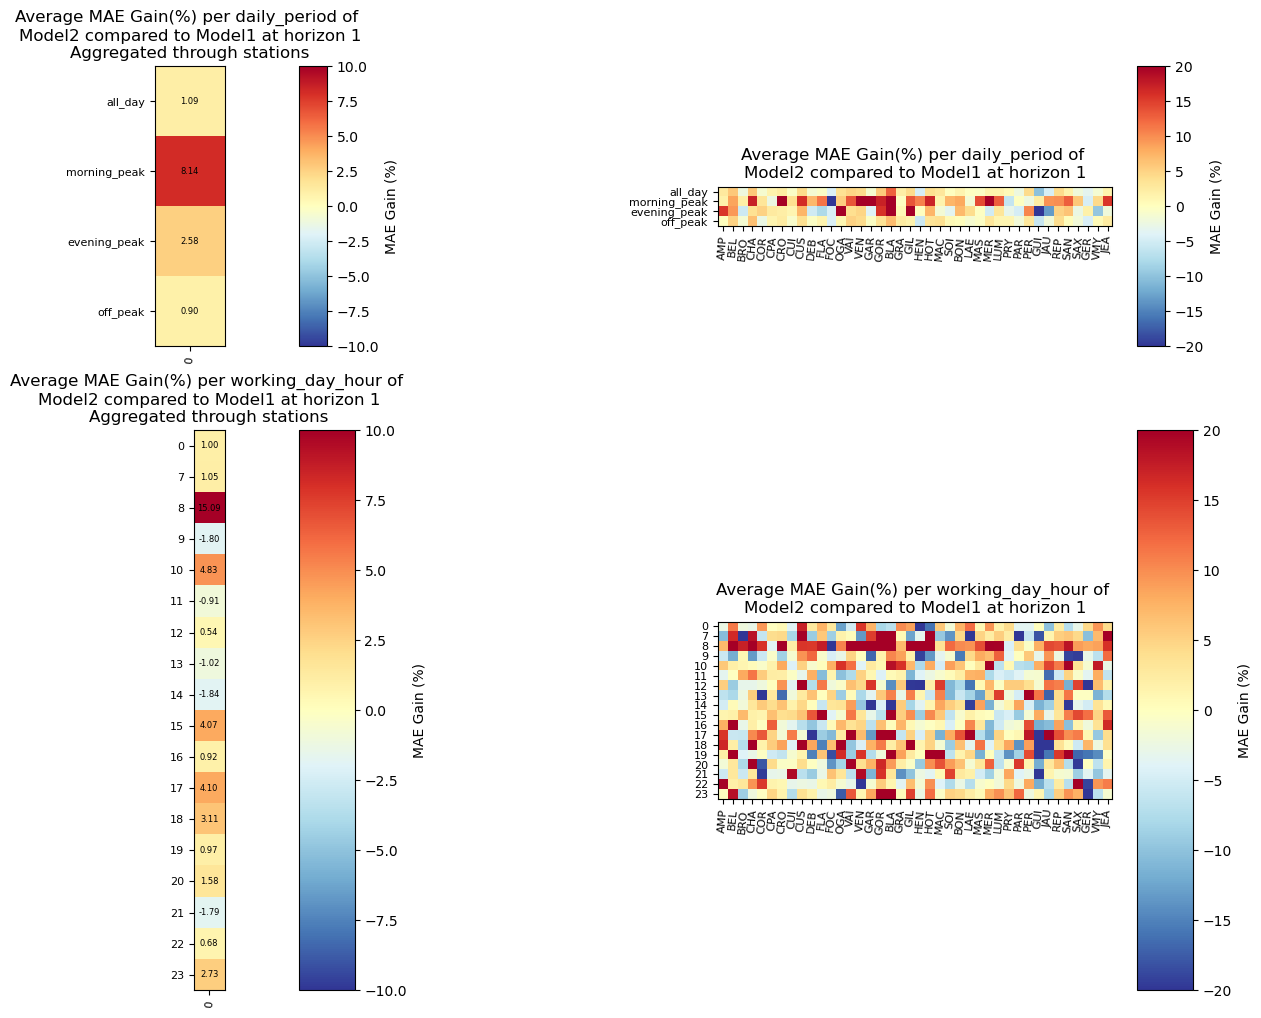

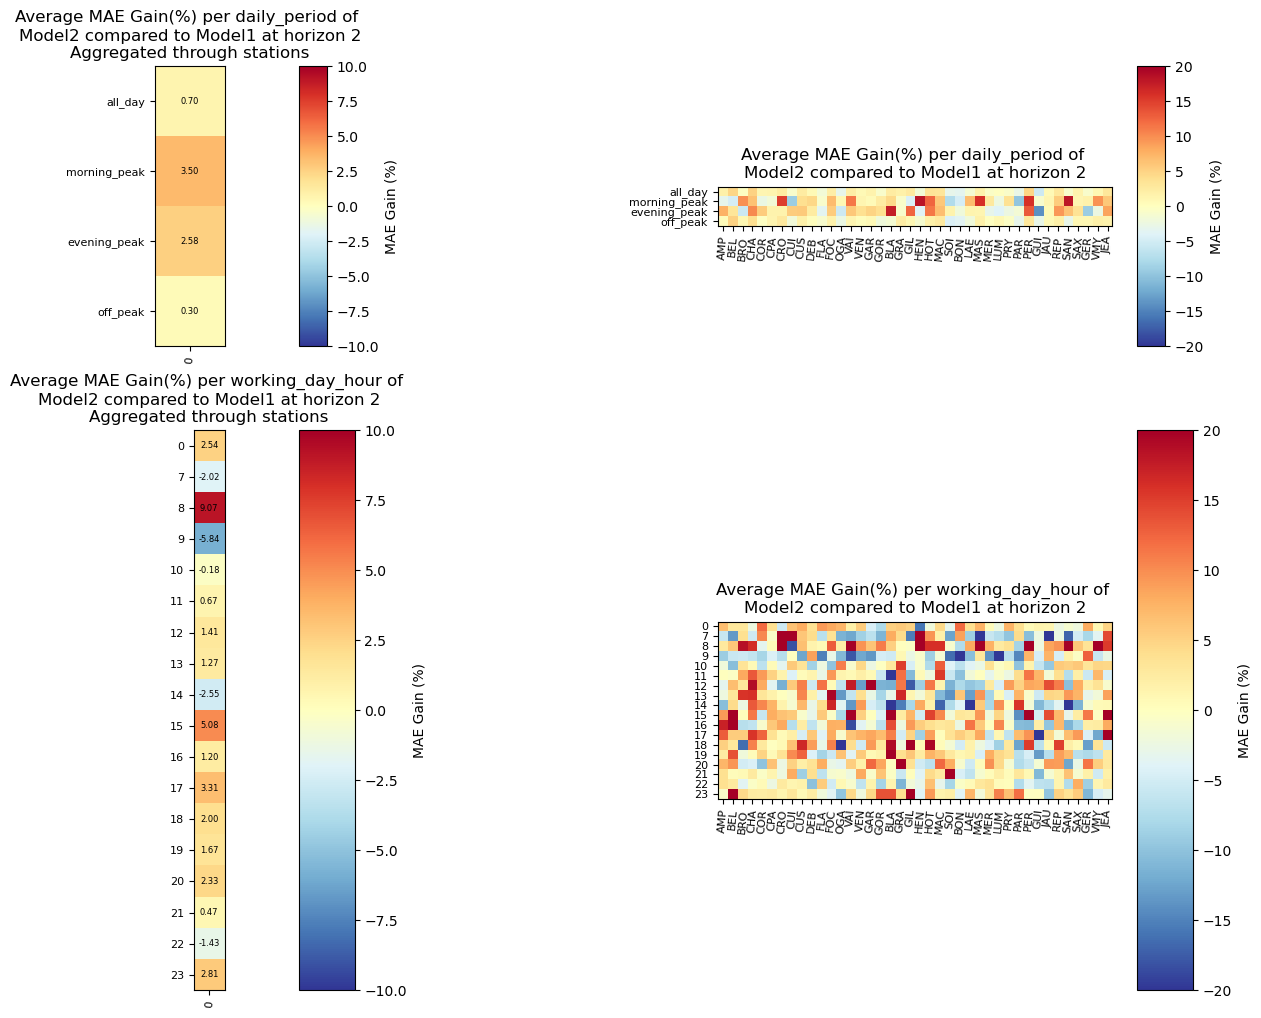

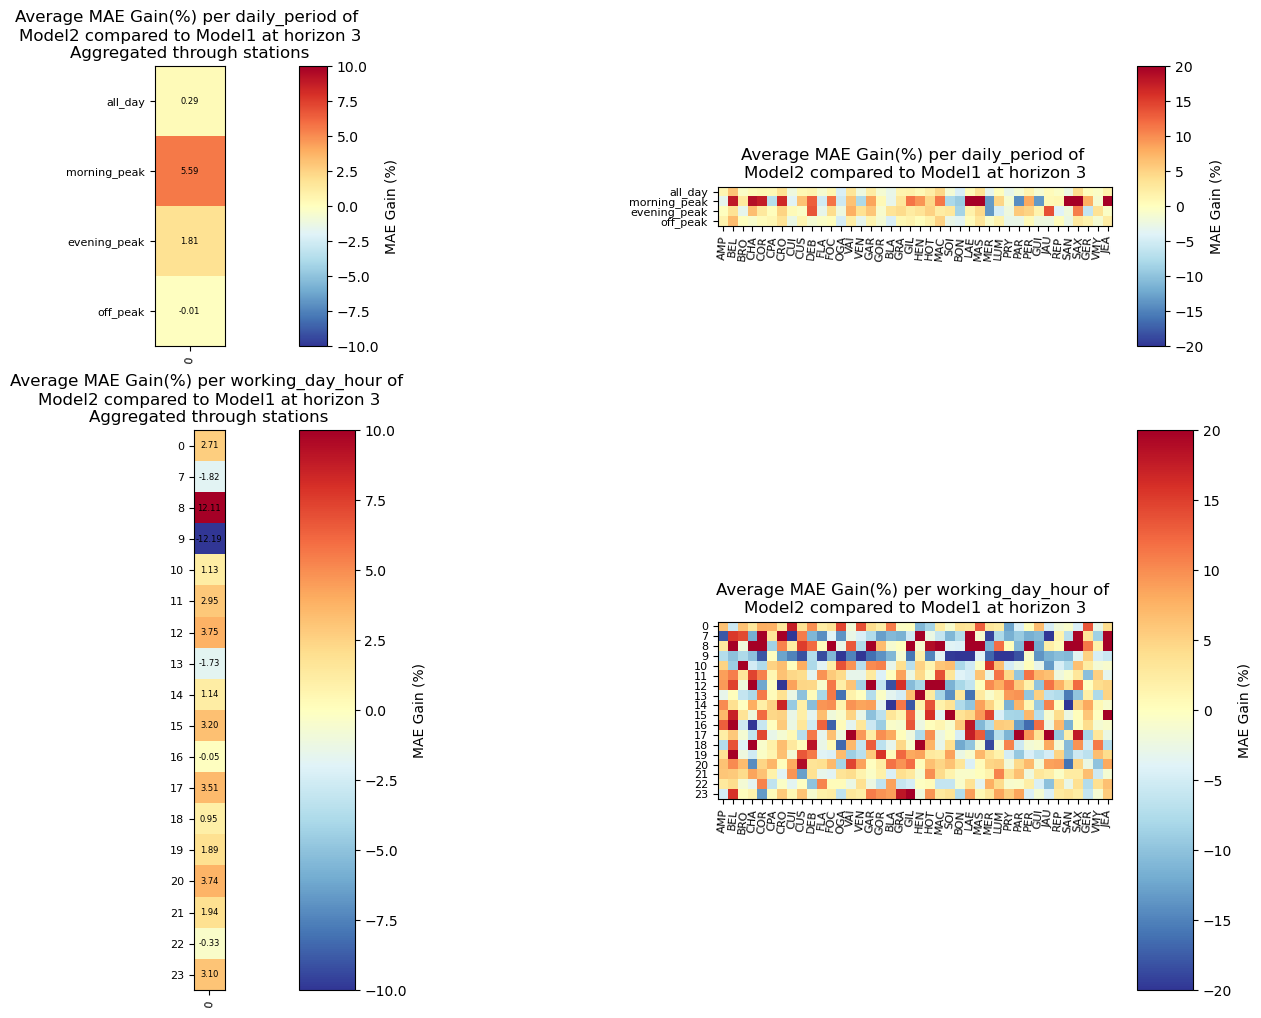

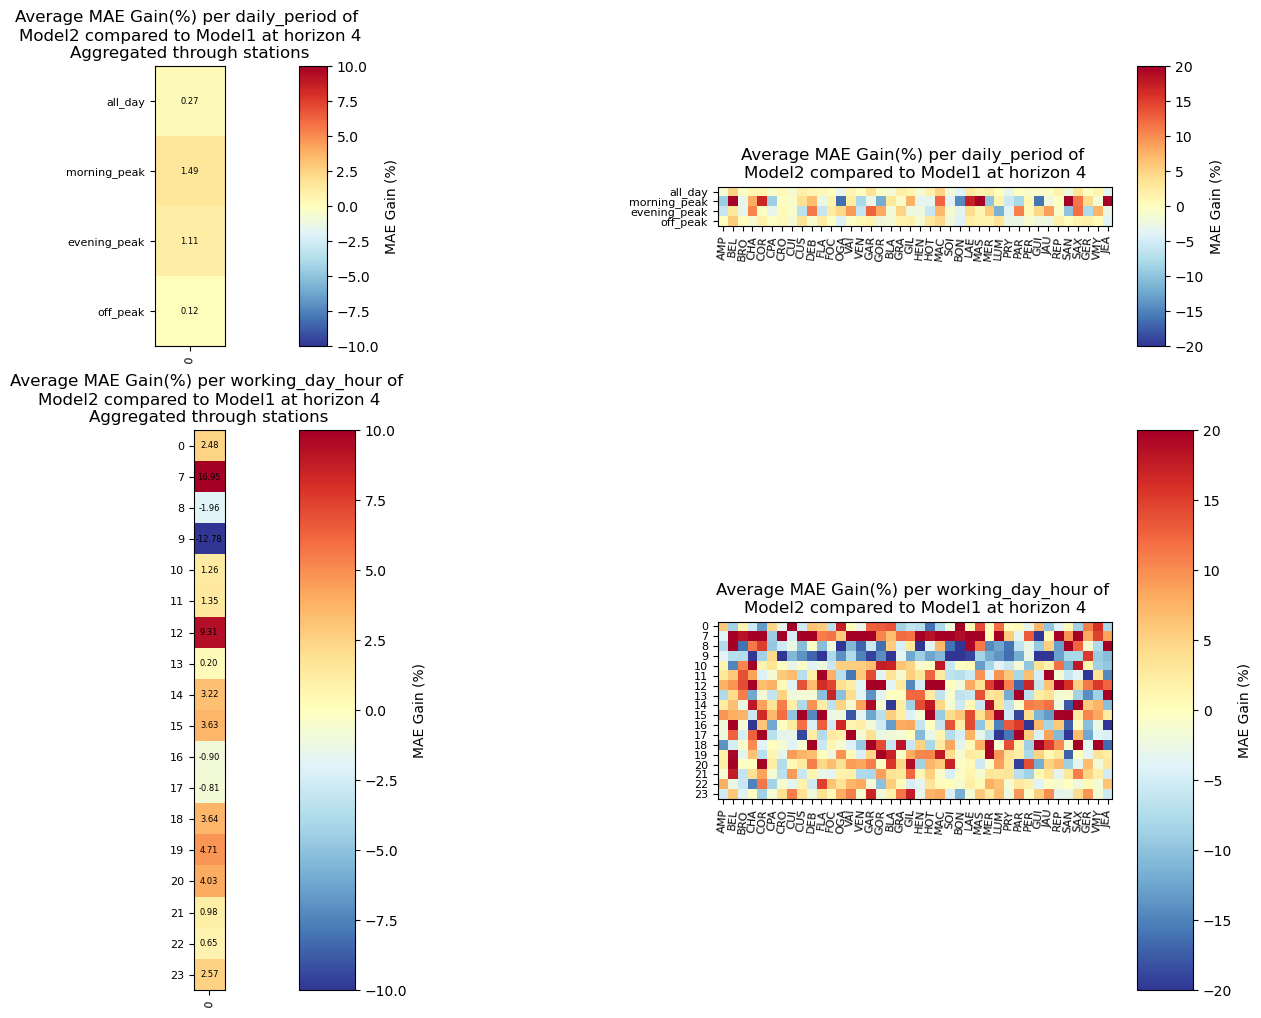

In [ ]:
min_flow = 20
step_ahead_max = args_init1.step_ahead
temporal_aggs =  ['daily_period','working_day_hour'] # ['hour','date','weekday'] 'hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour'
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
station_i = stations.index(station)
metric_list = ['mae'] # ['mae','mase','rmse']


# ---- Print global information ----
print_global_info(trial_id1,trial_id2,full_predict1,full_predict2,Y_true,ds1)
dic_error_agg_h = {}

# ---- plot gain between models ----
for step_ahead in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step): # range(1,step_ahead_max+1):   
    h_idx = step_ahead// args_init1.horizon_step

    # Get previous and predictions
    previous,predict1,predict2,real = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)

    # Plotting
    dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)
    dic_gain_agg,dic_error_agg = plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode,metrics = metric_list,step_ahead = step_ahead)  # ['mse','mase','mape']
    dic_error_agg_h[step_ahead] = dic_error_agg



# ---- plot temporal series profil of predictions ----
p = plot_profile_comparison_between_2_prediction(args_init1,full_predict1,full_predict2,real,ds1,station_i,station, width=900, height=400, bool_plot = True)


# ---- Print local inofrmation ----
for L_metric in [[metric] for metric in metric_list]:
    print(f'\nModel: {args_init1.model_name}')
    for daily_period in ['morning_peak','evening_peak','all_day']:
        print(daily_period)
        for metric in L_metric: 
            print(' ',metric.upper())
            if metric == 'rmse':
                metric_i = 'mse'
            else:
                metric_i = metric
            error1_per_h = [np.mean([dic_error_agg_h[h][metric_i]['daily_period']['error_pred1_agg'][station][daily_period] for station in ds1.spatial_unit]) for h in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step)]
            error2_per_h = [np.mean([dic_error_agg_h[h][metric_i]['daily_period']['error_pred2_agg'][station][daily_period] for station in ds1.spatial_unit]) for h in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step)]
            if metric == 'rmse':
                error1_per_h = [np.sqrt(x) for x in error1_per_h]
                error2_per_h = [np.sqrt(x) for x in error2_per_h]

            print('   Model 1: ',error1_per_h)
            print('   Model 2: ',error2_per_h)
# import numpy as np 
# for metric in ['mae']:
#     print(f'\nGlobal {metric.upper()} gain (%):')
#     for peak_name in ['morning_peak','evening_peak','off_peak']:
#         print(f"  {peak_name}: {'{:.3}'.format(np.mean([dic_gain[metric]['daily_period'][c][peak_name] for c in ds1.spatial_unit]))}%")

# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False
                'freq':'15min'}

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if False: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    #add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    add_name_id2 = 'NETMOB_POIS_maps_Deezer_concat_early_DL_IRIS'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


## Have a look on some interpolation:

In [3]:
# 'DA_method': 'magnitude_warping'
# 'DA_method': 'rich_interpolation'
# 'DA_method': 'interpolation'

modification = {'shuffle':False,
                'DA_method' : ['magnitude_warping','rich_interpolation'],
                'data_augmentation' : True 
                }


save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id2 = 'concat_early'
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

training_mode = 'train'
inputs = [[x,y,x_c] for  x,y,x_c in ds2.dataloader[training_mode]]
nb_contextual_data = len(inputs[0][2])
X = torch.cat([x for x,_,_ in inputs],0).to(trainer2.args.device)
Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer2.args.device)
X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer2.args.device)  for k in range(nb_contextual_data)]
X_c_one = [torch.ones(x_c.size()).to(trainer2.args.device) for x_c in X_c]

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776



Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek dat

<Axes: >

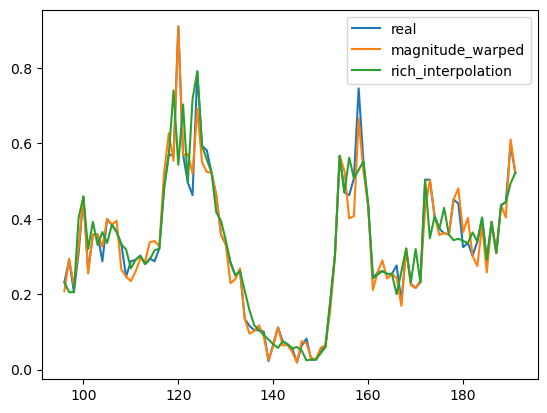

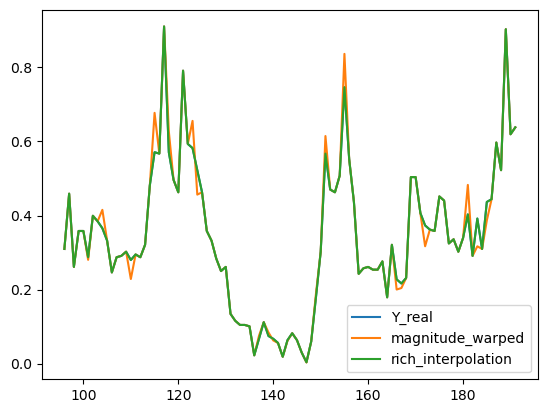

In [10]:
n = X.size(0)//3
station_i = 0

L = -3

pd.DataFrame({'real': X[:n,station_i,L].detach().cpu(),
              'magnitude_warped':X[n:2*n,station_i,L].detach().cpu(),
              'rich_interpolation':X[2*n:,station_i,L].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()


pd.DataFrame({'Y_real': Y_true[:n,station_i,0].detach().cpu(),
              'magnitude_warped':Y_true[n:2*n,station_i,0].detach().cpu(),
               'rich_interpolation':Y_true[2*n:,station_i,0].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meilleur model, et que c'est bien celui qu'on Load.

In [4]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}\n")

In [3]:
display_consistency(trainer1,ds1,save_folder1,trial_id1,add_name_id1,training_mode = 'test')
display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 1319.26



,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1230.919019,20.847181,36.719215,5382.383880,0.558646,6.967195,1128.664185,19.996849,33.227039
1,test,1288.185107,21.260062,36.229020,4998.188979,1.045187,84.935830,1286.441650,20.617752,29.995420


MSE errror on test by loading trained model : 1286.44



## Checking if Contetual Data are taken into account
- Set the Tensor associated to contextual data as 0 Tensor 
- Do the prediction 
- Compare the associated metrics

In [9]:
def check_impact_of_contextual_data(trainer,ds,training_mode = 'test'):
    inputs = [[x,y,x_c] for  x,y,x_c in ds.dataloader[training_mode]]
    nb_contextual_data = len(inputs[0][2])
    X = torch.cat([x for x,_,_ in inputs],0).to(trainer.args.device)
    Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer.args.device)
    X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer.args.device)  for k in range(nb_contextual_data)]
    X_c_one = [torch.ones(x_c.size()).to(trainer.args.device) for x_c in X_c]

    trainer.model.eval()
    with torch.no_grad():
        Preds = trainer.model(X,X_c)
        Preds_no_contextual = trainer.model(X,X_c_one)
        
    Preds = Preds.detach().cpu()
    Preds_no_contextual = Preds_no_contextual.detach().cpu()
    Y_true = Y_true.detach().cpu()
    Preds = ds.normalizer.unormalize_tensor(inputs = Preds,feature_vect = True).reshape(-1)     #  device = self.args.device
    Preds_no_contextual = ds.normalizer.unormalize_tensor(inputs = Preds_no_contextual,feature_vect = True).reshape(-1)     #  device = self.args.device
    Y_true = ds.normalizer.unormalize_tensor(inputs = Y_true,feature_vect = True).reshape(-1)     # device = self.args.device

    error_pred1 = ((Y_true - Preds)**2).mean()
    error_pred_contextual_null = ((Y_true - Preds_no_contextual)**2).mean()

    print(f"MSE errror on {training_mode} set by loading trained model :\nWith contectual data: {'{:.2f}'.format(error_pred1.item())}")
    print(f"Without contectual data: {'{:.2f}'.format(error_pred_contextual_null.item())}")
    print(f"Associated MSE Gain {'{:.1%}'.format(1-error_pred1.item()/error_pred_contextual_null.item())}")

check_impact_of_contextual_data(trainer2,ds2,training_mode = 'test')

MSE errror on test set by loading trained model :
With contectual data: 1286.44
Without contectual data: 2206.18
Associated MSE Gain 41.7%


## Production de Visuel :

In [ ]:
# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode)
previous,predict1,predict2,real = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,step_ahead,step_ahead_max)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

## Get Naiv Error and Model1 Error: 

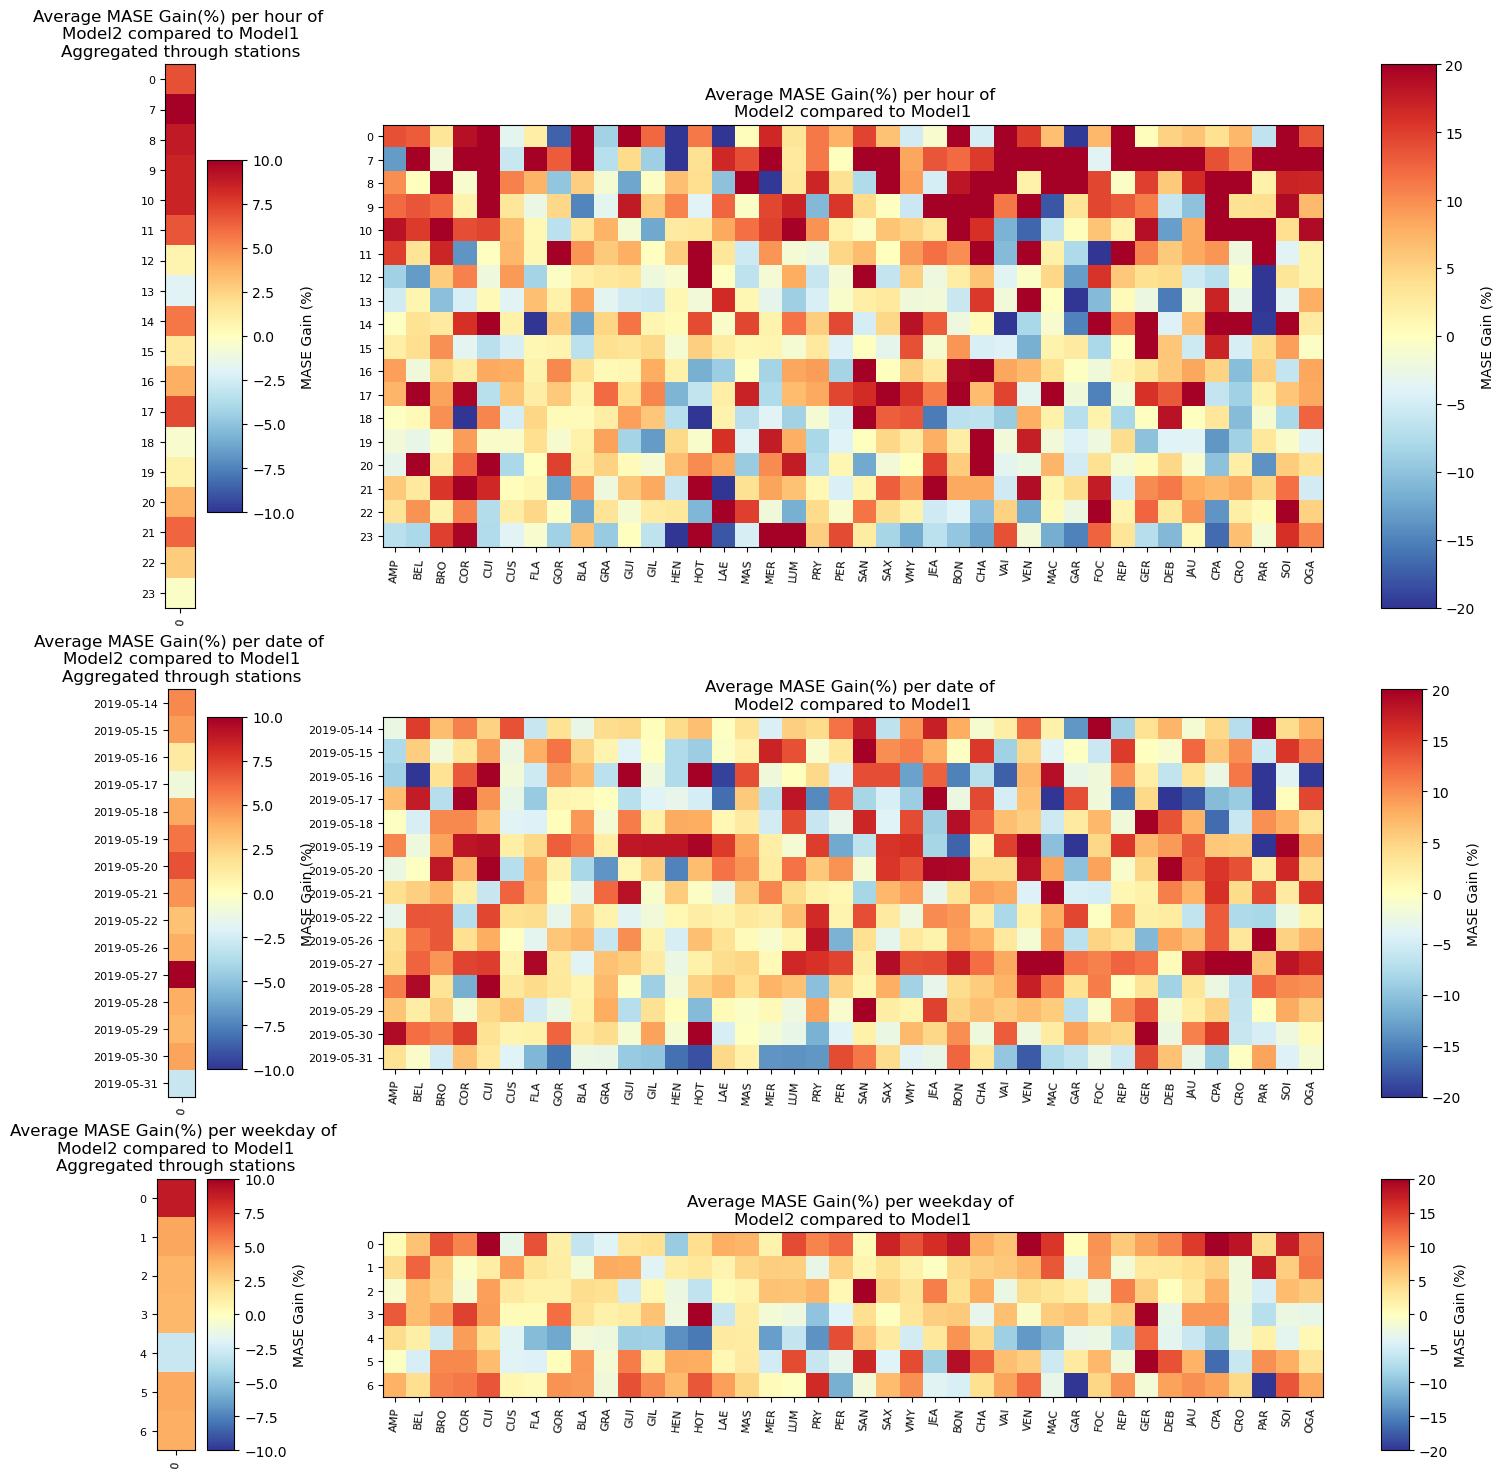

In [6]:
temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)


plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)

"""
fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]})
for i,temporal_agg in enumerate(temporal_aggs):
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    # agg All sations  
    plt.sca(axes[i,0])
    plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
    axes[i,0].set_title(title)

    # Per station 
    plt.sca(axes[i,1])
    plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
    axes[i,1].set_title(title) 
"""


## Load Data 

In [ ]:
modification_bis = {'train_pourcent' : 100}

target_data = 'PeMS08_flow'#'PeMS08_flow'#'CRITER_3_4_5_lanes_flow' #'subway_in'  # PeMS03 # PeMS04 # PeMS07 # PeMS08 # METR_LA # criter
dataset_names = ['PeMS08_flow'] # ['CRITER_3_4_5_lanes_flow','netmob_POIs']  #['CRITER_3_4_5_lanes_flow']#['PeMS08_flow','PeMS08_occupancy','PeMS08_speed'] # ['subway_in','calendar_embedding'] #['PeMS03'] #['subway_in'] ['subway_in','subway_indiv'] #["subway_in","subway_out"] # ['subway_in','netmob_POIs_per_station'],["subway_in","subway_out"],["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage =['PeMS08_flow'] # ['CRITER_3_4_5_lanes_flow','netmob_POIs'] #['PeMS08_flow'] # ['subway_in','netmob_image_per_station']#['subway_in','subway_indiv'] # ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STAEformer'

config_file = importlib.import_module(f"constants.config_by_datasets.{target_data}.{model_name}")
importlib.reload(config_file)
modification = config_file.config
SEED = config_file.SEED
set_seed(SEED)
modification.update(modification_bis)
args_init = local_get_args(model_name,
                args_init = None,
                dataset_names=dataset_names,
                dataset_for_coverage=dataset_for_coverage,
                modification = modification)


trainer,ds  = load_trainer_ds_from_1_args(args_init,modification = modification)


for training_mode in ['train','valid','test']:
    print('\nTraining mode: ',training_mode)
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)


    predicted_dates = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1]
    mini_d,maxi_d = predicted_dates.min(),predicted_dates.max()
    print(f'    X,Y,X_c size: ',X.size(),Y.size(),[xc.size() for xc in X_c])
    print(f'    Predicted dates ({len(predicted_dates)}): {mini_d} - {maxi_d}' )
    print(f'    Supposed to contains: {len(pd.date_range(mini_d,maxi_d,freq=f"{int(60/ds.time_step_per_hour)}min"))} dates')

## Plot Time Series on specific station: 

<Axes: >

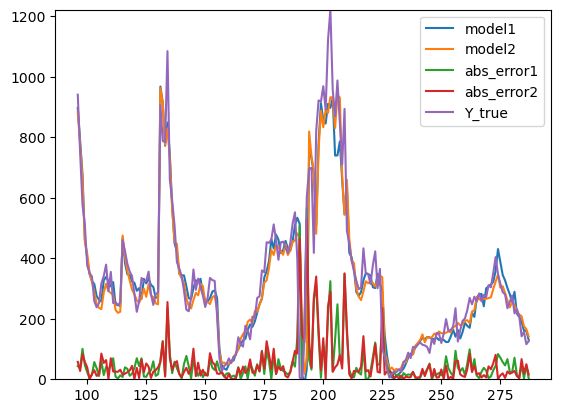

In [6]:
station = 'BEL'
start_day = 1
nb_days = 2


station_i = list(ds1.spatial_unit).index(station)
pred1 = predict1[:,station_i].numpy()
pred2 = predict2[:,station_i].numpy()
ytrue = real[:,station_i].numpy()

error_abs1 = dic_error['mae']['error_pred1'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
error_abs2 = dic_error['mae']['error_pred2'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
naive_error = dic_error['mae_naiv']['error_naiv'].reshape(-1,len(ds1.spatial_unit))[:,station_i]

ax = pd.DataFrame({'model1':pred1,
              'model2':pred2,
              'abs_error1':error_abs1,
              'abs_error2':error_abs2,
              'Y_true':ytrue 
              }).iloc[start_day*96:96*(start_day+nb_days)]
ax.plot(ylim = [0,ytrue[start_day*96:96*(start_day+nb_days)].max()])

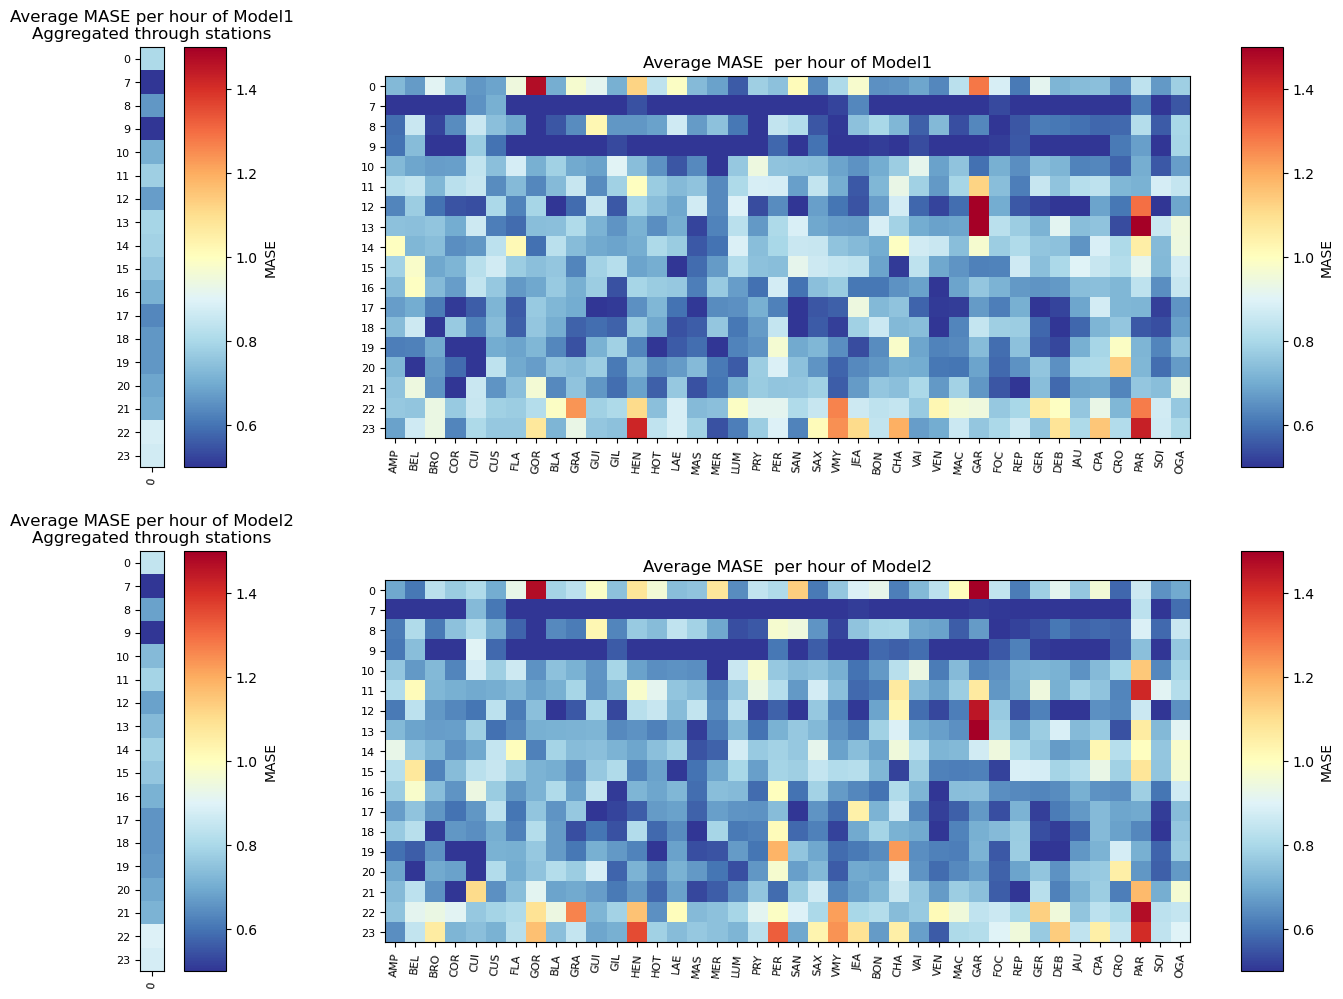

In [10]:
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
temporal_aggs = ['hour'] #['weekday_hour_minute','weekday_hour','hour','date','weekday']
for temporal_agg in temporal_aggs:
    fig, axes = plt.subplots(2, 2, figsize=(max(8,0.5*len(stations)),get_y_size_from_temporal_agg(temporal_agg)),gridspec_kw={'width_ratios': [2,5]})
    df_gain21,df_mase1,df_mase2 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    for i,df_mase in enumerate([df_mase1,df_mase2]):
        # agg All sations  
        plt.sca(axes[i,0])
        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_mase).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE per {temporal_agg} of Model{i+1}\nAggregated through stations'
        axes[i,0].set_title(title)

        # Per station 
        plt.sca(axes[i,1])
        plot_coverage_matshow(pd.DataFrame(df_mase),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE  per {temporal_agg} of Model{i+1}'
        axes[i,1].set_title(title) 


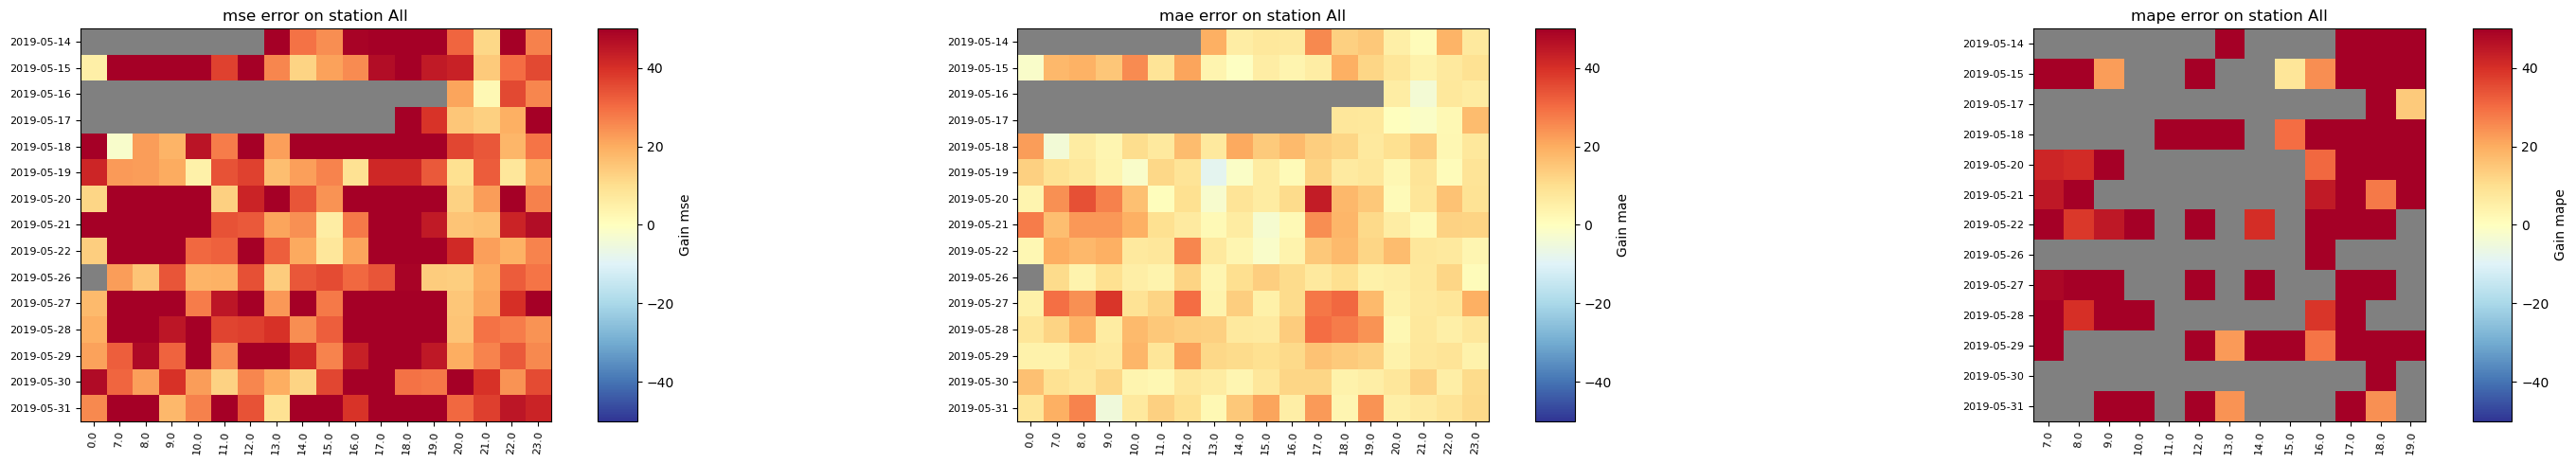

(<Figure size 3000x500 with 6 Axes>,
 array([<Axes: title={'center': 'mse error on station All'}>,
        <Axes: title={'center': 'mae error on station All'}>,
        <Axes: title={'center': 'mape error on station All'}>],
       dtype=object))

In [11]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'

# index_matshow in :  ['weekday','hour','month_year','date','day_date']
# columns_matshow in :  [None, 'weekday','hour','month_year','date','day_date']

gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = False,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
training_mode = 'test'
station = ['CHA','PAR','PER']
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)

In [3]:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/'
add_name_id1 = ''
trial_id1 ='subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017'
trainer,ds,args = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification={})

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
T_subway_out:  torch.Size([7392, 40])
vision_input_type POIs
vision_model_name None
2821 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481
Considered Spatial-Unit:  Index(['AMP', 'BEL', 'BRO', 'COR', 'CUI', 'CUS', 'FLA', 'GOR', 'BLA', 'GRA',
       'GUI', 'GIL', 'HEN', 'HOT', 'LAE', 'MAS', 'MER', 'LUM', 'PRY', 'PER',
       'SAN', 'SAX', 'VMY', 'JEA',

In [6]:
layer = 0
training_mode = 'test'
attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
num_heads = len(attn_model)

X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

In [11]:
import gc
import torch.nn as nn 
gc.collect()
torch.cuda.empty_cache()

original_temporal_agg = trainer.model.core_model.output.temporal_agg
model_until_temporal_MHA = trainer.model
model_until_temporal_MHA.core_model.output.temporal_agg = nn.Identity()


trainer.model.eval()
with torch.no_grad():
    intermediate_output = model_until_temporal_MHA(X,X_c)

gc.collect()
torch.cuda.empty_cache()

In [12]:
intermediate_output.size()

torch.Size([940, 40, 1])

In [ ]:

for head in attn_model:
    enhanced_x,attn_weights = head(X,X_c)

In [ ]:
def plot_attn_weight(trainer,nb_calendar_data,ds= None,training_mode = None,temporal_agg = None,save=None,stations= None,layer = None):
    attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
    num_heads = len(attn_model)
    
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

    # Init:
    nb_contextuals = len(X_c) - nb_calendar_data
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations) 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)
    num_cols = 4

    nb_rows = (nb_stations_to_plot*num_heads + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_contextuals//num_cols))))

    vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
    for station_i in range(nb_stations_to_plot):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = attn_model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        if attn_weights.dim()==4:
            for attn_head_i in range(num_heads):
                attn_weights_reshaped = attn_weights[:,attn_head_i,:,:].squeeze(1).detach().cpu().numpy()  # Shape [B, P]
                # Temporal Aggregation of attn weight:
                attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
                ax = plt.subplot(nb_rows, num_cols, station_i*num_heads+attn_head_i + 1)  # Créer un subplot
                im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
                plt.colorbar(im,label='Attention Weight',shrink = 0.25)
                
                if temporal_agg is None:
                    plt.title(f'Attention Weight head {attn_head_i}\nof station {station_ind} ({spatial_units[station_ind]}) \nfor each sample of the batch')
                    plt.ylabel('Samples')
                else:
                    plt.title(f'Mean Attention Weight head {attn_head_i}\nof station {station_i}({spatial_units[station_ind]}) \nby calendar class') 
                    plt.ylabel('Calendar class')
                plt.xlabel('Contextual time-series')


                num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
                plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
                plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

    plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

## Fine Tuning on Specific Moments : 
- !!! ICI besoin de 'shuffle = True' parce qu'on train le model (fine-tuning)

## Fly-by transit:
#### Concept existants:
- Stop-Less Autonomous Modular (SLAM) (testé à dubai en 2018) : micro bus qui peuvent se concatener si besoin (opour en faire des plus gros), et qui sont indépendant également si beson . Permet de distribuer correctement les usagers selon leur destinations. A Dubai: 6 seats et 4 debout par mini bus (capacity 10).
L'idée c'est d'arrêter de faire des stops. 
- AMB aussi à produit des prototype du henre.

Limite dans le cas d'utilisation 'massive': pas inclusif, les vieux peuvent pas aler d'un module à un autre. Même pour marcher entre deux module c'est pas incroyable. Puis dans tout les cas on a jamais 2 passagers qui ont les mêmes OD. 
#### Leur proposition: 
proposer leur propre model mais en préservant la dimension 'transport public'. 
Propose de décomposer en tout petit moduel, pour 1 a 2 personne. Pouvant se mettre par exemple en platoon etc.
## Question : 
- que faire dnas le cas où bu va d'un point A à un point B, dont la majorité de ses usagers font ce trajet ?
- Enormement de 'sous module': technologie embarquée, seat à laver après chaque utilisation/journée, réparation etc... finalement pas de coût de driver mais énormément d'autres coûts, s'assurer en permanance de la sécurité de chaque unité (high speed, donc dangereux), les réparations etc...
- Utilisation de la capacité 'urbaine': acutellement beaucoup de congestion. ça ne devrait pas les aider, d'autant plus que si on permet à tout le monde de se déplacer ça va encourager des 'micro' déplacement', qui prennent de la place sur le réseau (contrairement à des mobilités douces types vélo, ou contrairement a des gros system de transport type metro / bus grande capacité).
- C'est moins cher que le Taxi par personne transporté. Mais on ne veut pas un taxi par personne.  comparaiosn avec un model non souhaitable.
- Compare le prix avec une voiture éléctrique. Mais la on parle d'un truc autonome.
- Surement des moment et endroit où quand la demande est importante, il y a aura des centaines de Trailers qui devront se déplacer au même endroit, et ça va générer d'énorme problème logistique.


## Benchmark Comparison between models: 

In [1]:
import pandas as pd
from examples.benchmark import local_get_args,keep_track_on_model_metrics
from examples.train_and_visu_non_recurrent import train_the_config,get_ds_without_shuffling_on_train_set
from plotting.TS_analysis import plot_TS


def get_TS_prediction(trainer,ds,stations_to_plot='CHA',training_mode='test',name= ''):
    spatial_units  = list(ds.spatial_unit)
    station_indices = [spatial_units.index(station) for station in stations_to_plot]
    predict,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    df_pred =  pd.DataFrame({f'{name}_{spatial_units[station_i]}_Pred':predict[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_true = pd.DataFrame({f'{spatial_units[station_i]}_Y_true': Y_true[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].values
    return df_pred,df_true,index_df

Training and Hyper-parameter tuning with Ray is not possible


Training and Hyper-parameter tuning with Ray is not possible
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 1889
number of trainable parameters: 1889

start training
epoch: 0 
 min\epoch : 0.08
Estimated time for training: 2.0min 

Training Throughput:3139.53 sequences per seconds
>>> Training complete in: 0:01:56.890262
>>> Training performance time: min 0.00694584846496582 avg 0.009059906005859375 seconds (+/- 0.006282888286802044)
>>> Loading performance time: min 0.00015854835510253906 avg 0.0062623259501425775 seconds (+/- 0.014081617299986991)
>>> Forward performance time: 0.0009820986656757377 sec

Loading BokehJS ...

<Axes: >

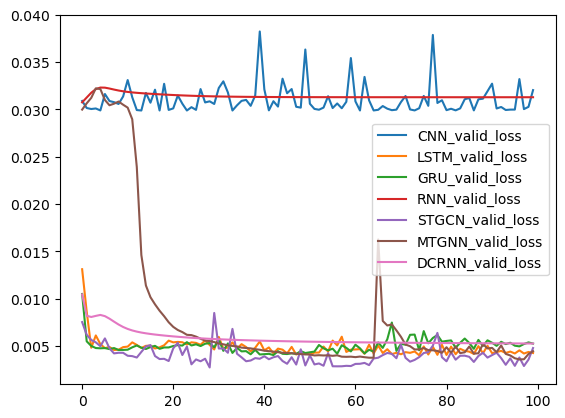

In [1]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'
df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

modification = {'epochs' : 100, #100,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True

                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['CNN','LSTM','GRU','RNN','STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}
for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()


In [2]:
df_results

,Model,Valid_loss,Valid_mse,Test_mse,Valid_mae,Test_mae,Valid_mape,Test_mape
0,CNN,0.029883,18683.888672,17581.490234,92.898766,87.686371,284.523895,218.150238
0,LSTM,0.004042,2056.194824,2027.486328,27.648268,27.326344,40.493713,36.615929
0,GRU,0.004063,2078.000488,2051.144531,27.521818,27.205008,45.601322,40.368877
0,RNN,0.030743,19329.923828,18687.574219,90.831963,86.728508,242.366821,185.635788
0,STGCN,0.002752,1368.745239,1421.312134,22.125439,22.203094,38.124065,34.790466
0,MTGNN,0.003603,1870.807617,1942.013184,26.149363,26.374453,46.093781,40.294285
0,DCRNN,0.005282,2824.918213,2873.498779,31.813610,32.829212,57.927681,54.280727


>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713

start training
epoch: 0 
 min\epoch : 1.29
Estimated time for training: 18.8min 

Training Throughput:692.55 sequences per seconds
>>> Training complete in: 0:05:10.429930
>>> Training performance time: min 0.014720678329467773 avg 0.02728891372680664 seconds (+/- 0.06569723933859964)
>>> Loading performance time: min 0.00013709068298339844 avg 0.03701392448955633 seconds (+/- 0.6139421012670077)
>>> Forward performance time: 0.031157050568967972 seconds (+/- 0.06124145142530242)
>>> Backward performance time: 0.007092571333569874 seconds (+/- 0.003103940249793853)
>>> Plotting performance time: 1.2173944590

Loading BokehJS ...

<Axes: >

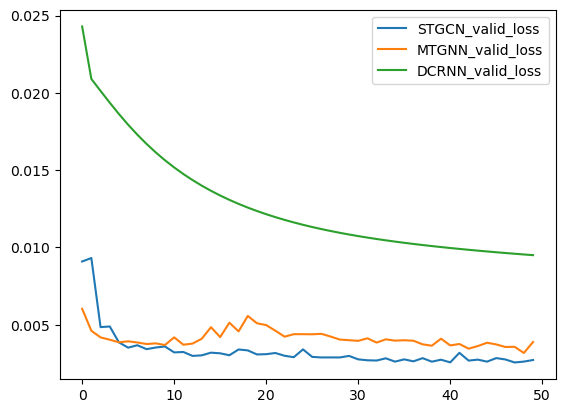

In [2]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'

df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
modification = {'epochs' : 50, #100,
                'lr': 0.00135,
                'weight_decay': 0.0733390536333296,
                'batch_size': 32,
                'dropout': 0.3187398629441463,
                'scheduler': None,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True
                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}

for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()

In [7]:
from examples.load_best_config import load_args_of_a_specific_trial
add_name_id = ''
trial_id ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'
fold_name = 'complete_dataset'
args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)
args.lr

0.00135

In [10]:
for arg_i in ['lr','weight_decay','batch_size','dropout','scheduler']:
    print(f"'{arg_i}': {getattr(args,arg_i)},")

'lr': 0.00135,
'weight_decay': 0.0733390536333296,
'batch_size': 32,
'dropout': 0.3187398629441463,
'scheduler': nan,
